# Desarrollo de un sistema de recomendación para una detección eficiente de adsorbentes

*Autor: Celeste Castro Granados (celsgazu@ciencias.unam.mx)*

*Fecha de realización: 1 de mayo de 2024*

Este notebook corresponde a la versión final del problema de la detección eficiente de adsorbentes. El sistema propuesto fue desarrollado durante la tesis de Celeste Castro Granados, bajo la supervisión del Dr. Xim Bokhimi. Para ejecutarlo utilizar el entorno de anaconda `pytorch`.

 El proceso de construcción y calibración del modelo, junto con todas las pruebas realizadas y archivos generados, se encuentran en la carpeta `Recommender-Adsorbentes`. El objetivo de este notebook es sintetizar todo lo trabajado y servir de guía para implementar el sistema propuesto. Es completamente autocontenido.

La base de datos empleada fue obtenida del siguiente artículo:

`Zhang, X., Sethi, S., Wang, Z., Zhou, T., Qi, Z., & Sundmacher, K. (2022). A neural recommender system for efficient adsorbent screening. Chemical Engineering Science, 259, 117801.` 

# Paso 0: Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import seaborn as sns 

/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.6.2
numpy       1.23.5
pandas      1.5.2
seaborn     0.12.2
sinfo       0.3.1
torch       1.9.0
torchvision 0.10.0
-----
IPython             8.13.2
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.3
-----
Python 3.9.16 (main, Mar  8 2023, 14:00:05) [GCC 11.2.0]
Linux-3.10.0-1160.36.2.el7.x86_64-x86_64-with-glibc2.17
56 logical CPU cores, x86_64
-----
Session information updated at 2024-06-24 19:53


La celda anterior muestra las versiones de todas las librerías utilizadas en este notebook con el fin de garantizar su reproducibilidad. Asimismo, al ejecutarla se genera automáticamente un archivo txt con dicha información. 

# Planteamiento del Problema

La adsorción es un proceso en el cual un líquido o un gas se adhiere a la superficie de un sólido, formando una película delgada sobre ella. Las moléculas del gas o líquido se conocen como adsorbato, y el sólido como adsorbente. 

<div>
<img src="/home/celeste/tesis/recommender/Recommender-Adsorbentes/imagenes/adsorcion.jpg" width='350'/>
</div>

La base de datos es construida a partir de la extracción de isotermas monocomponentes de adsorción de la base de datos del NIST (National Institute of Standards and Technology). Cada isoterma es una colección de puntos de datos de adsorción para un par adsorbente-adsorbato particular; para varias presiones y una temperatura dada. La información de las isotermas puede representarse mediante una matriz, donde las columnas representan combinaciones de `adsorbato-temperatura-presión` y las filas representan `adsorbentes`. Nos referiremos a las columnas como `gases`. Las entradas de la matriz corresponden a los adsorption uptakes (en unidades de mol/kg) o capacidades de adsorción de los diferentes gases en la superficie de los sólidos, a las diferentes temperaturas y presiones específicadas.

Para algunos adsorbentes sólo se conocen un número limitado de isotermas. Para un par adsorbente-adsorbato, si la isoterma está disponible, el elemento correspondiente de la matriz se llena, si no, está vacío. Por lo tanto, se tiene una matriz incompleta. El problema de predecir isotermas faltantes puede formularse como un problema de completar de dicha matriz. El sistema que se desarrollará servirá para predecir todas las entradas faltantes de la matriz. 

Para completar la matriz, se utiliza el método de `filtrado colaborativo neuronal` (basado en una red neuronal), en conjunto con los datos de las entradas completas de la matriz. Este es el enfoque más popular dentro del mundo de los sistemas de recomendación. 

Como se sabe de la termodinámica básica, las interacciones entre adsorbentes y adsorbatos generalmente se describen mediante modelos altamente no lineales. Para abordar esta no-linealidad se aplica el enfoque de redes neuronales, donde las interacciones no lineales pueden ser bien aprendidas por las funciones de activación no lineales. Específicamente, se construye una red neuronal autocodificadora. Finalmente, una vez que la matriz esté completa, podría aplicarse para la identificación y recomendación de adsorbentes prometedores, en el caso particular del artículo, se identificaron adsorbentes para el almacenamiento de metano y separación de eteno/etano. 


## Paso 1: Importación de las bases de datos

En el repositorio asociado al artículo, se incluyen los archivos y el proceso de construcción de la base de datos. En este notebook, vamos a importar la base de datos completa proporcionada, y posteriormente, será anulado un porcentaje aleatorio de las entradas; mismas que serán las que serán completadas por el sistema. De este modo, será posible evaluar con datos reales el desempeño del modelo.

In [3]:
matriz_incompleta = pd.read_excel('/home/celeste/tesis/recommender/Recommender-Adsorbentes/datos/Complete_matrix.xlsx')

In [4]:
matriz_incompleta

,Unnamed: 0,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,1.792624,0.844962,0.000000,0.037800,0.301248,0.315355,0.109140,0.000000,...,3.252520,4.343379,3.062861,7.023981,27.645334,3.130662,4.991338,11.163347,6.986485,11.954864
1,"(15,15) SWSiCNT",1.139975,0.885577,0.460885,0.000000,1.262480,0.405857,0.179975,0.036291,0.000000,...,1.224523,2.756256,1.385274,1.459049,8.637432,1.470981,1.710555,2.344462,2.351026,3.173570
2,"(22,22) SWSiCNT",20.021545,3.040396,0.990242,0.000000,15.397470,0.444007,0.176597,0.014436,0.000000,...,13.341930,4.159455,8.135298,6.373383,50.843555,7.236180,21.686472,19.889746,16.274437,19.158159
3,(Cr)-MIL-101-SO3Ag,25.758533,6.673483,3.845711,0.160661,18.111420,1.598743,0.976192,0.762010,0.288756,...,18.540556,6.263205,11.620084,10.215974,50.234863,10.908710,27.539465,6.029259,24.667564,28.294613
4,(Cu(db)),5.991840,1.787435,0.920272,0.000000,0.257570,0.084687,0.491625,0.290457,0.000000,...,4.647121,4.533251,2.697064,2.656299,24.488384,2.806321,6.743752,6.470298,7.281785,7.176484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,1.079469,0.597944,0.000000,0.012183,0.474581,0.244710,0.047634,0.000000,...,1.980017,3.133307,1.682327,1.031747,3.965266,1.772706,3.037405,6.378811,5.463107,6.944499
1257,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.269992,0.311977,0.079905,0.000000,0.834529,0.103914,0.000000,0.000000,0.000000,...,0.346684,1.800818,0.402631,0.541453,1.890479,0.468515,0.450423,0.081222,0.810060,0.257930
1258,{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,2.136436,1.153096,0.025261,0.832732,0.829907,0.523100,0.368113,0.156124,...,1.549578,4.538204,2.999756,3.278202,24.443693,2.911840,1.229138,0.984888,1.959672,1.787560
1259,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},2.622934,1.725868,0.963068,0.000000,2.947596,0.707617,0.596164,0.398727,0.101568,...,3.318505,1.635280,2.231190,2.589295,10.409521,2.305397,3.507734,1.525428,3.373003,2.186897


# Paso 2: Análisis exploratorio y preprocesamiento de la base de datos 

Los gases que se consideran en la matriz son: 
* acetileno 
* argón 
* butano 
* dióxido de carbono 
* monóxido de carbono 
* etano 
* eteno 
* hidrógeno
* criptón
* metano
* nitrógeno
* oxígeno
* propano
* xenón

Cada columna está etiquetada con un código que indica el gas, la presión y la temperatura. Por ejemplo, la columna "0_acetylene273" se refiere al gas acetileno a una presión de 0 atmósferas y una temperatura de 273 K. Del mismo modo, la columna "1_acetylene298" se refiere al gas acetileno a una presión de 1 atmósfera y una temperatura de 298 K. Volvemos a recordar que las entradas de la matriz corresponden a los adsorption uptakes o captaciones de adsorción. A continuación visualizamos la matriz de datos:

In [5]:
matriz_incompleta.head()

,Unnamed: 0,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,1.792624,0.844962,0.000000,0.03780,0.301248,0.315355,0.109140,0.000000,...,3.252520,4.343379,3.062861,7.023981,27.645334,3.130662,4.991338,11.163347,6.986485,11.954864
1,"(15,15) SWSiCNT",1.139975,0.885577,0.460885,0.000000,1.26248,0.405857,0.179975,0.036291,0.000000,...,1.224523,2.756256,1.385274,1.459049,8.637432,1.470981,1.710555,2.344462,2.351026,3.173570
2,"(22,22) SWSiCNT",20.021545,3.040396,0.990242,0.000000,15.39747,0.444007,0.176597,0.014436,0.000000,...,13.341930,4.159455,8.135298,6.373383,50.843555,7.236180,21.686472,19.889746,16.274437,19.158159
3,(Cr)-MIL-101-SO3Ag,25.758533,6.673483,3.845711,0.160661,18.11142,1.598743,0.976192,0.762010,0.288756,...,18.540556,6.263205,11.620084,10.215974,50.234863,10.908710,27.539465,6.029259,24.667564,28.294613
4,(Cu(db)),5.991840,1.787435,0.920272,0.000000,0.25757,0.084687,0.491625,0.290457,0.000000,...,4.647121,4.533251,2.697064,2.656299,24.488384,2.806321,6.743752,6.470298,7.281785,7.176484


Renombramos la primera columna de la base y empezamos a explorar:

In [6]:
matriz_incompleta = matriz_incompleta.rename({'Unnamed: 0': 'Adsorbente'}, axis=1)

In [7]:
#Conteo de valores nulos
matriz_incompleta.isna().sum()

Adsorbente        0
0_acetylene273    0
0_acetylene298    0
0_argon298        0
0_butane298       0
                 ..
3_propane298      0
3_propane323      0
3_propene298      0
3_propene323      0
3_xenon298        0
Length: 91, dtype: int64

A primera vista no tenemos valores inválidos en la matriz, sin embargo, es necesario asegurarnos y convertir los datos de tipo NaN a ceros antes de ingresar la matriz a la red neuronal, para que no hayan problemas de procesamiento de los datos por parte de la red.

In [8]:
matriz_incompleta = matriz_incompleta.fillna(0)
matriz_incompleta.isna().sum()

Adsorbente        0
0_acetylene273    0
0_acetylene298    0
0_argon298        0
0_butane298       0
                 ..
3_propane298      0
3_propane323      0
3_propene298      0
3_propene323      0
3_xenon298        0
Length: 91, dtype: int64

In [9]:
matriz_incompleta.head()

,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,1.792624,0.844962,0.000000,0.03780,0.301248,0.315355,0.109140,0.000000,...,3.252520,4.343379,3.062861,7.023981,27.645334,3.130662,4.991338,11.163347,6.986485,11.954864
1,"(15,15) SWSiCNT",1.139975,0.885577,0.460885,0.000000,1.26248,0.405857,0.179975,0.036291,0.000000,...,1.224523,2.756256,1.385274,1.459049,8.637432,1.470981,1.710555,2.344462,2.351026,3.173570
2,"(22,22) SWSiCNT",20.021545,3.040396,0.990242,0.000000,15.39747,0.444007,0.176597,0.014436,0.000000,...,13.341930,4.159455,8.135298,6.373383,50.843555,7.236180,21.686472,19.889746,16.274437,19.158159
3,(Cr)-MIL-101-SO3Ag,25.758533,6.673483,3.845711,0.160661,18.11142,1.598743,0.976192,0.762010,0.288756,...,18.540556,6.263205,11.620084,10.215974,50.234863,10.908710,27.539465,6.029259,24.667564,28.294613
4,(Cu(db)),5.991840,1.787435,0.920272,0.000000,0.25757,0.084687,0.491625,0.290457,0.000000,...,4.647121,4.533251,2.697064,2.656299,24.488384,2.806321,6.743752,6.470298,7.281785,7.176484


## 2.1 Visualización de los datos: Construcción de histogramas

Iniciamos esta subsección generando histogramas de frecuencia de los valores contenidos en cada columna:

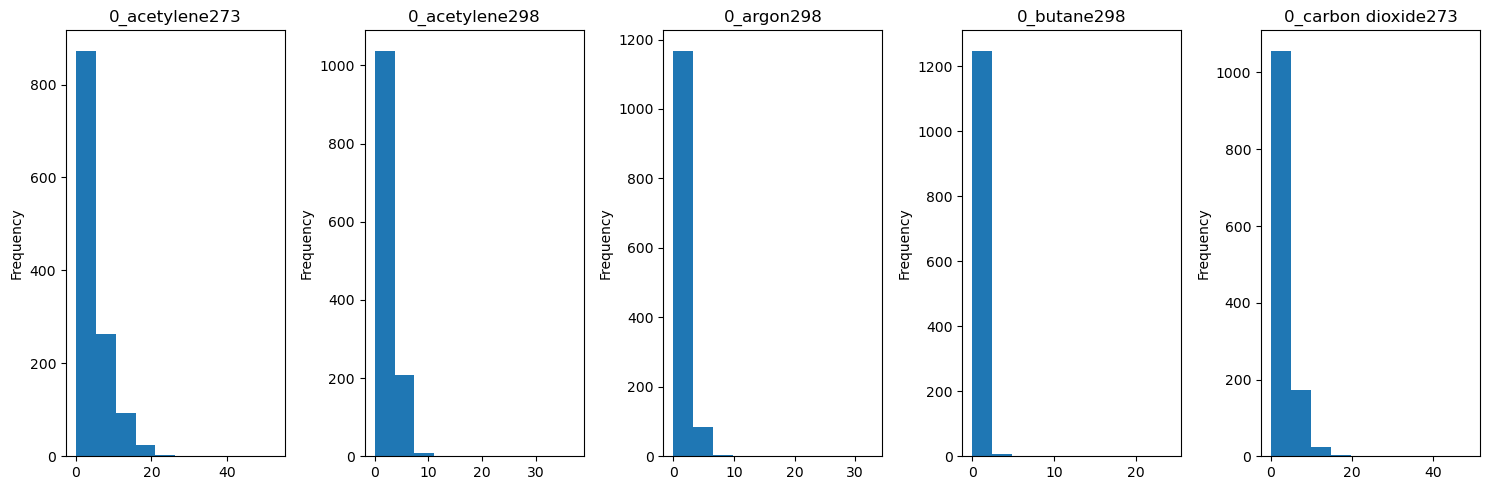

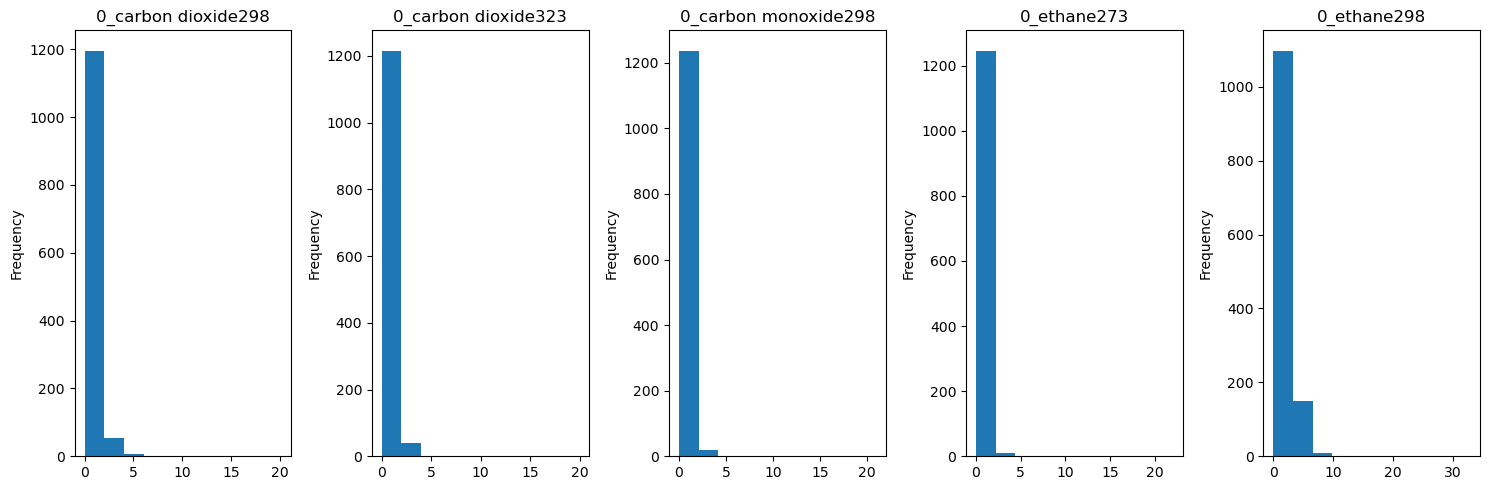

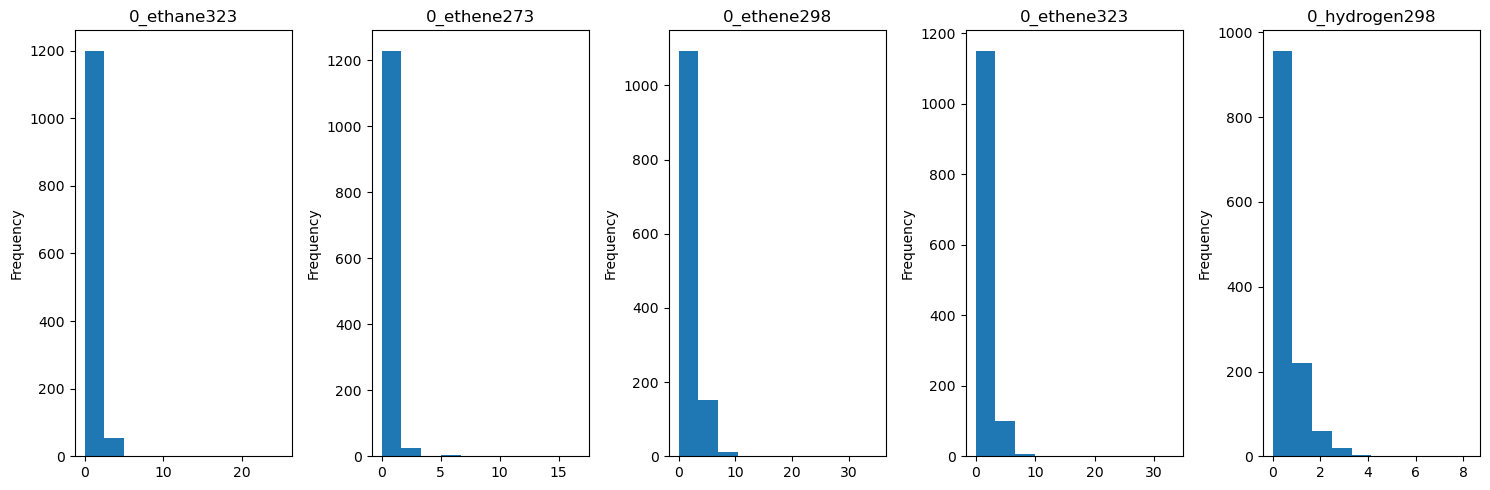

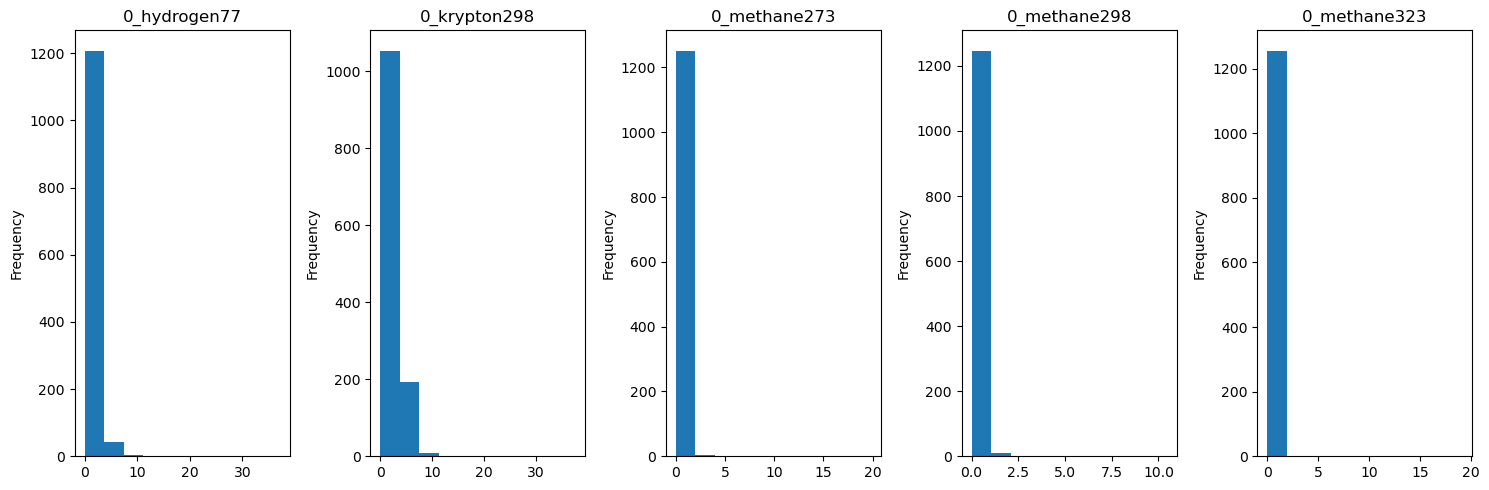

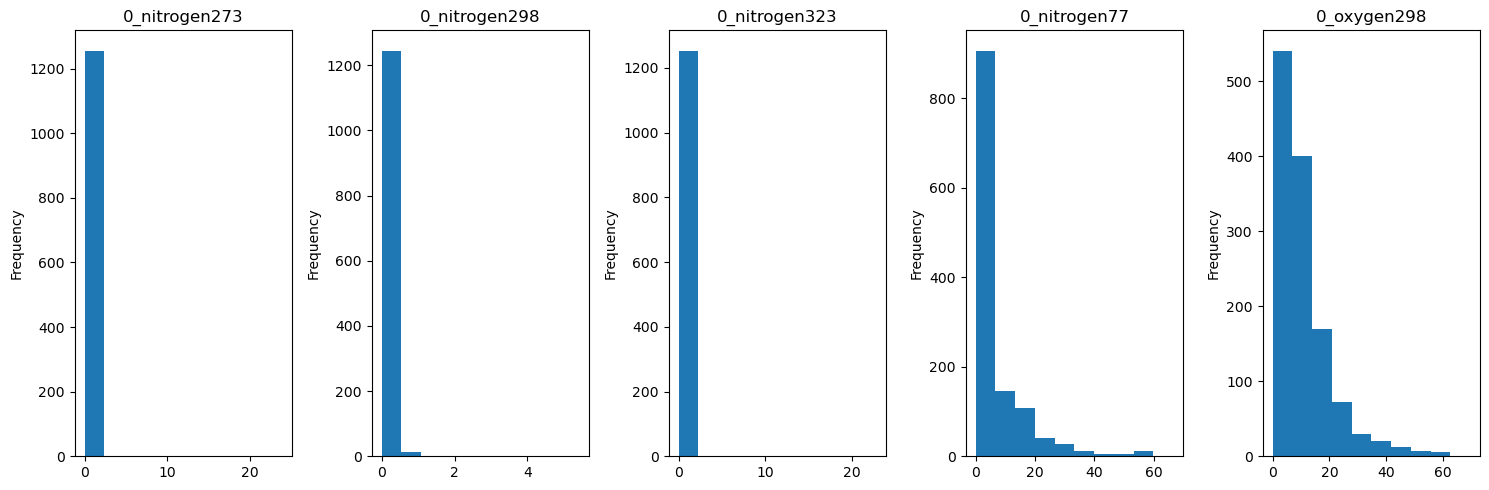

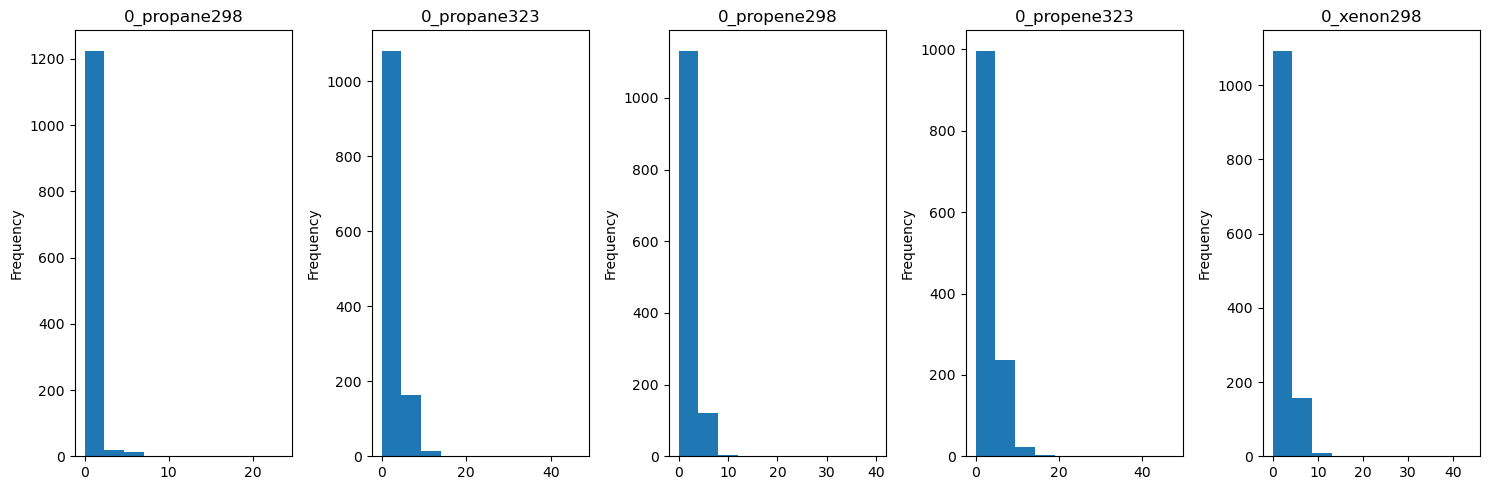

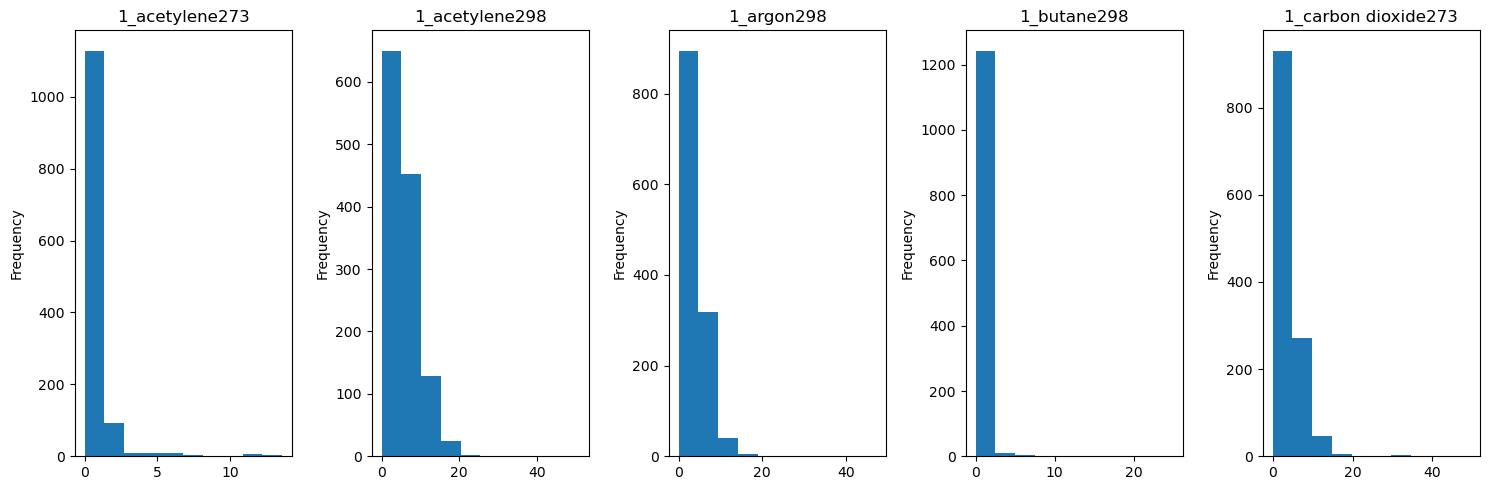

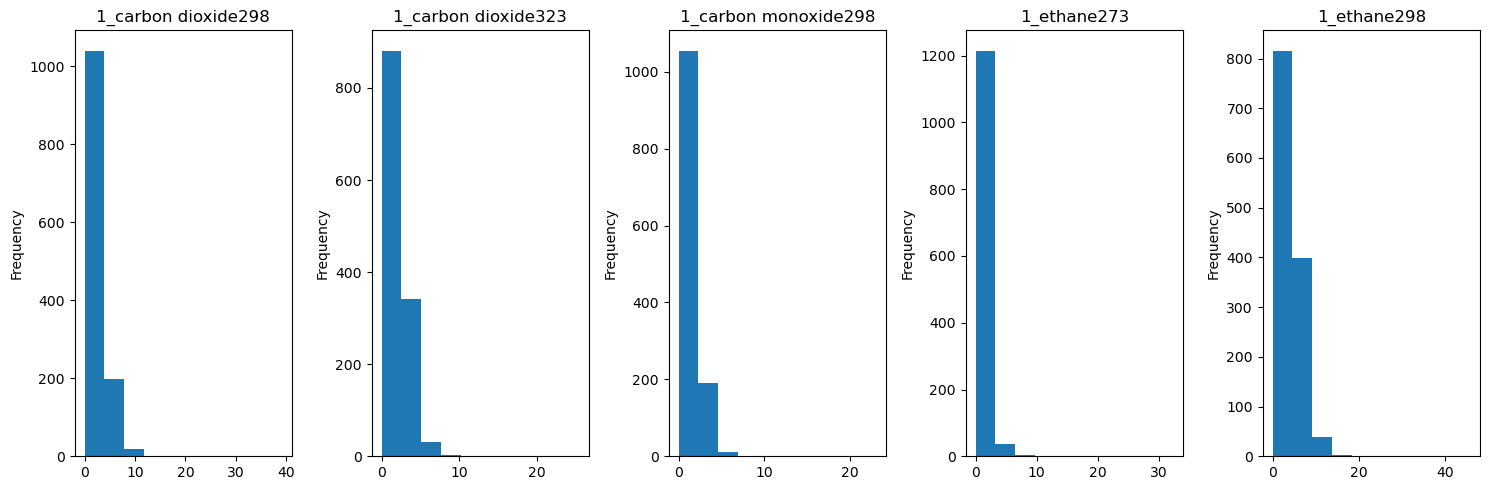

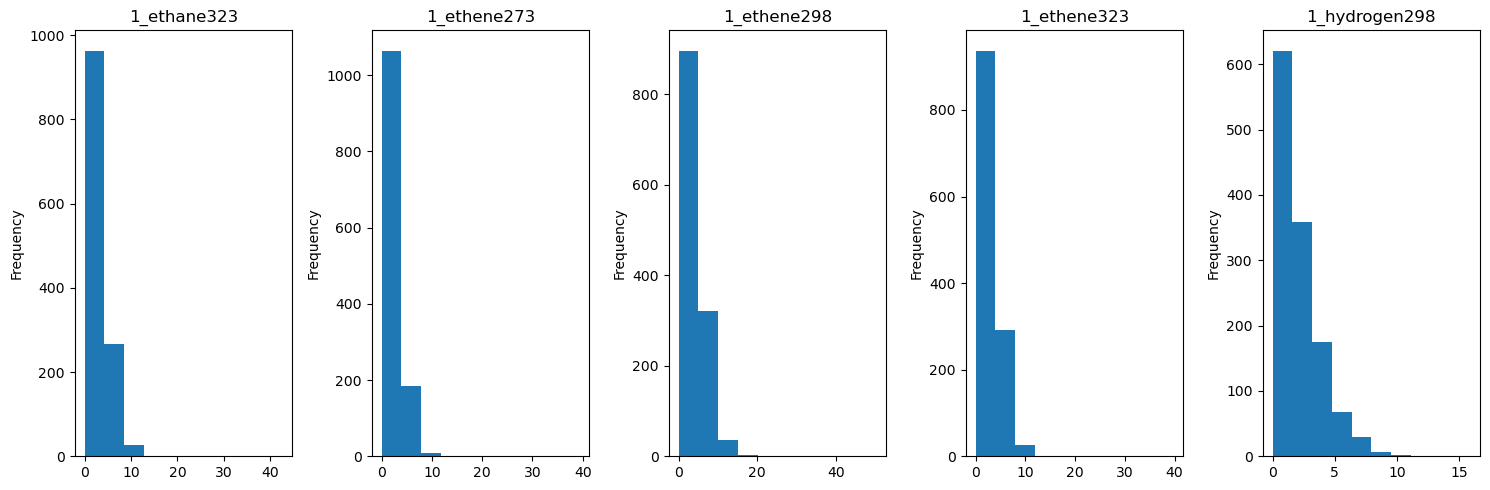

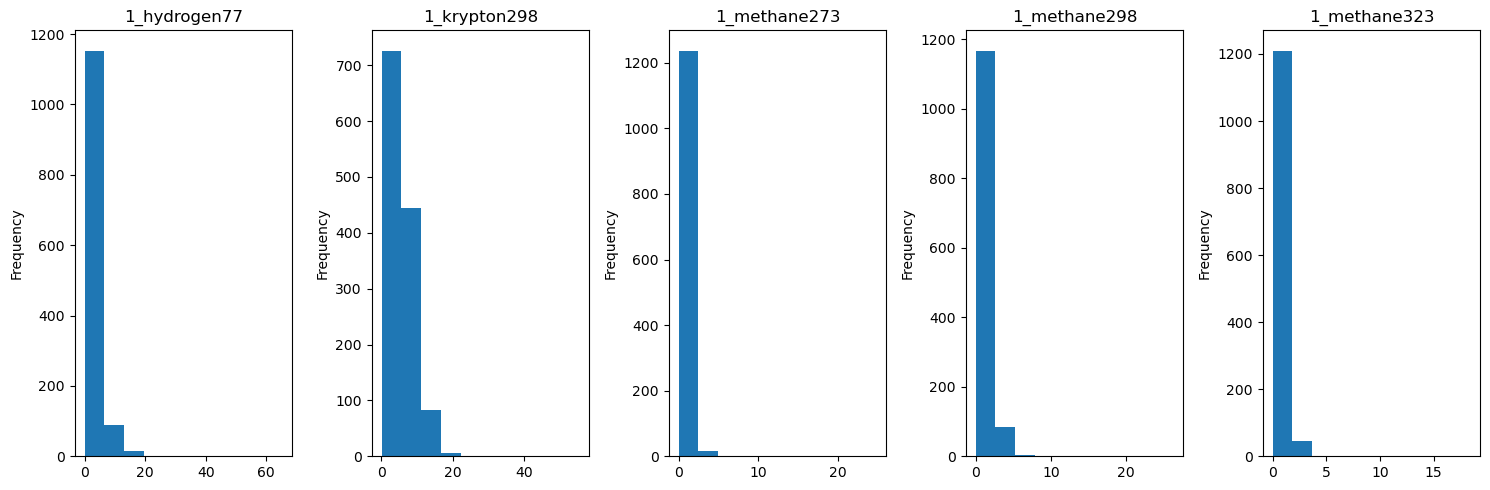

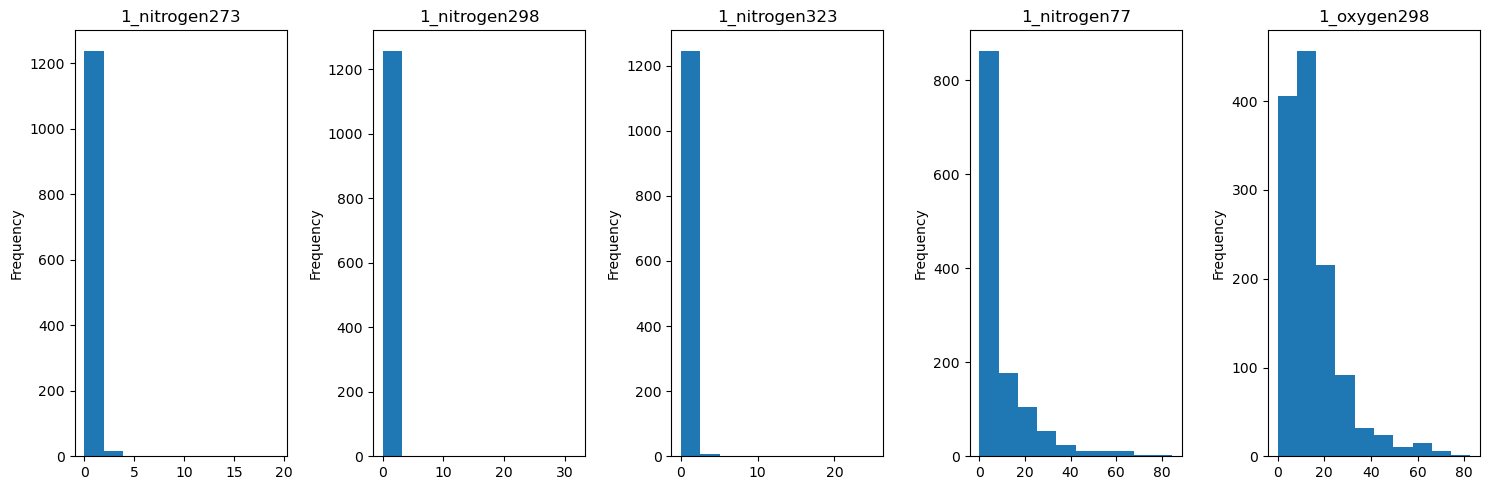

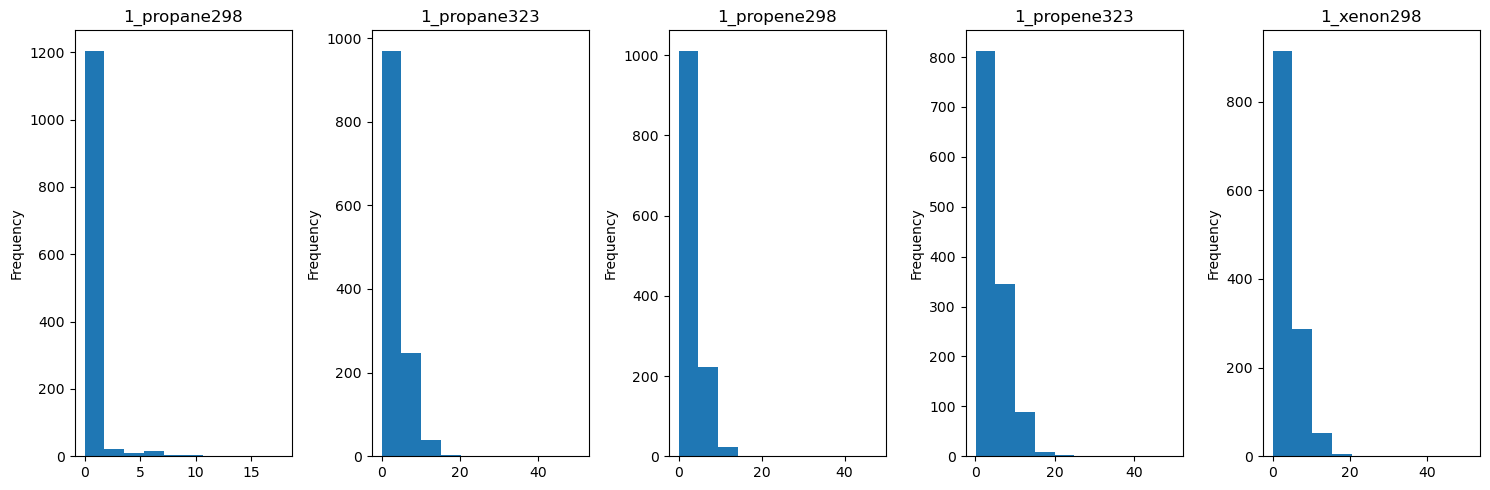

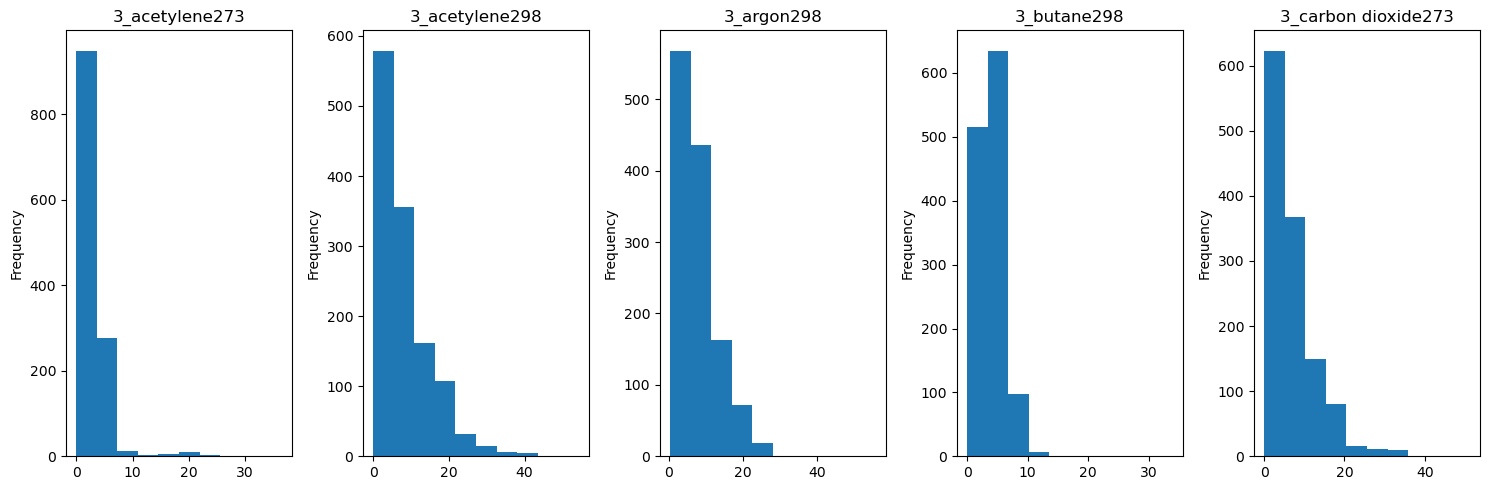

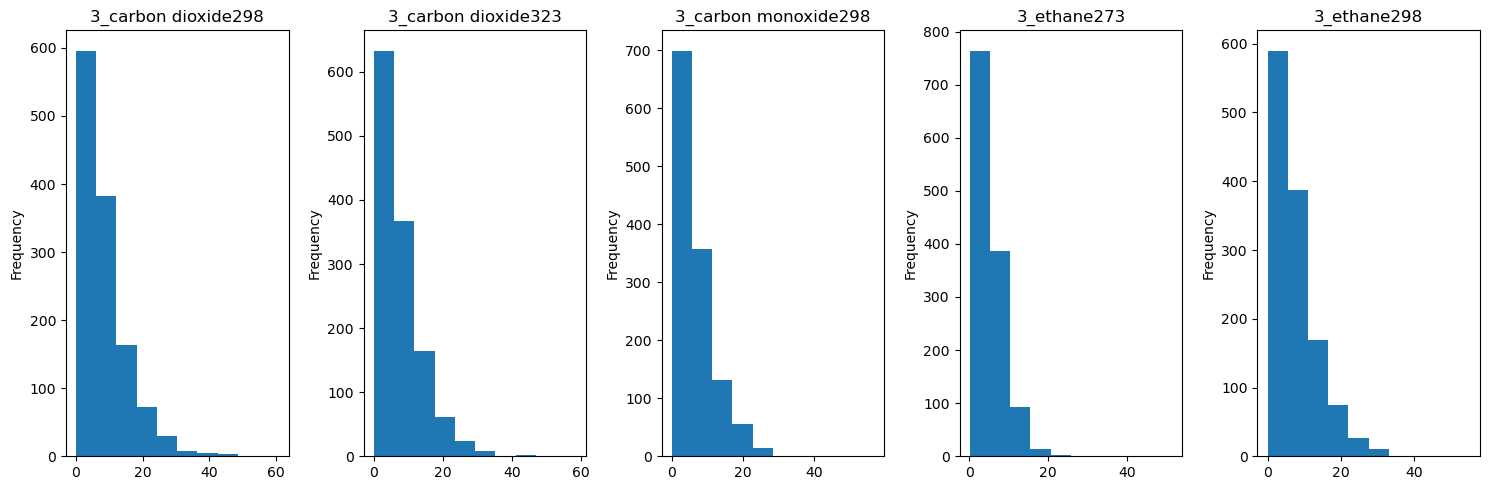

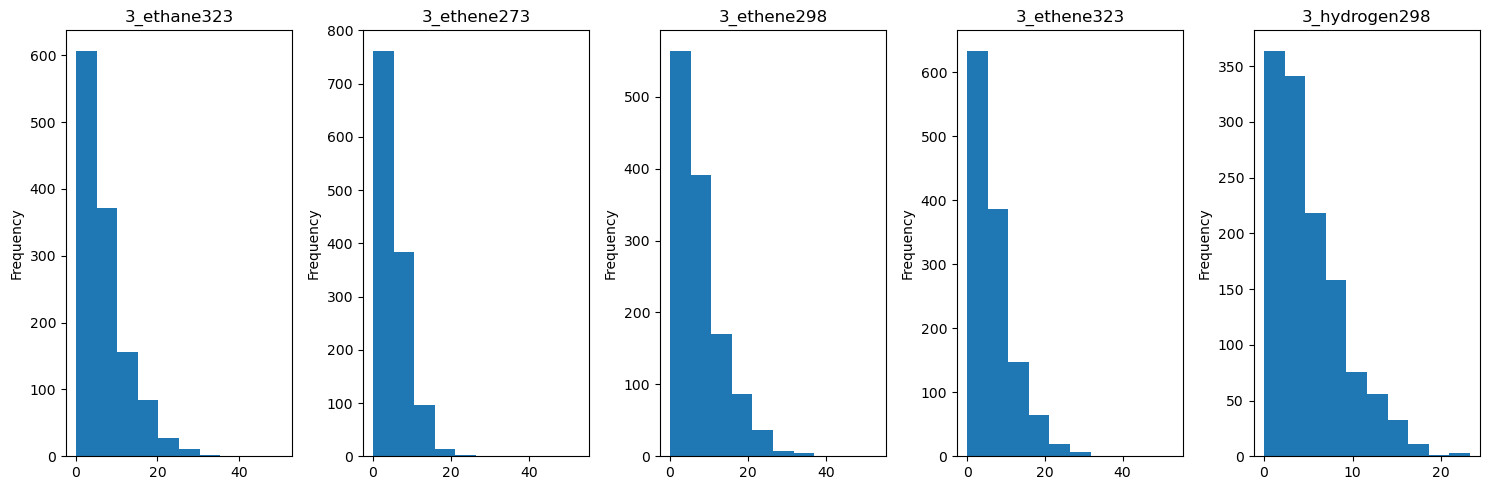

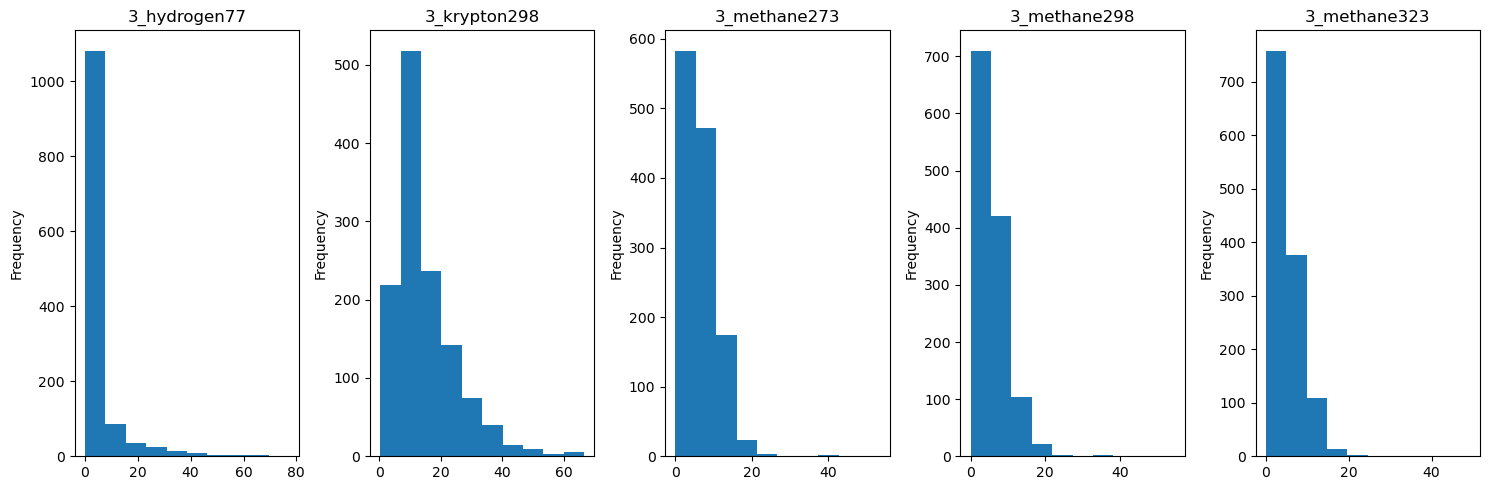

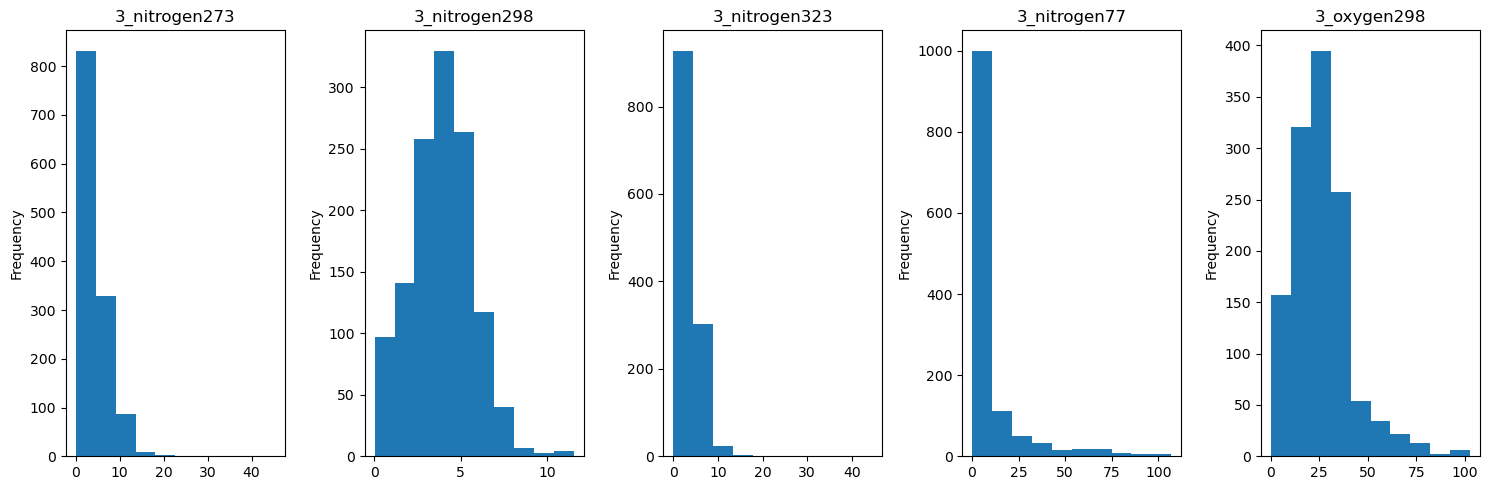

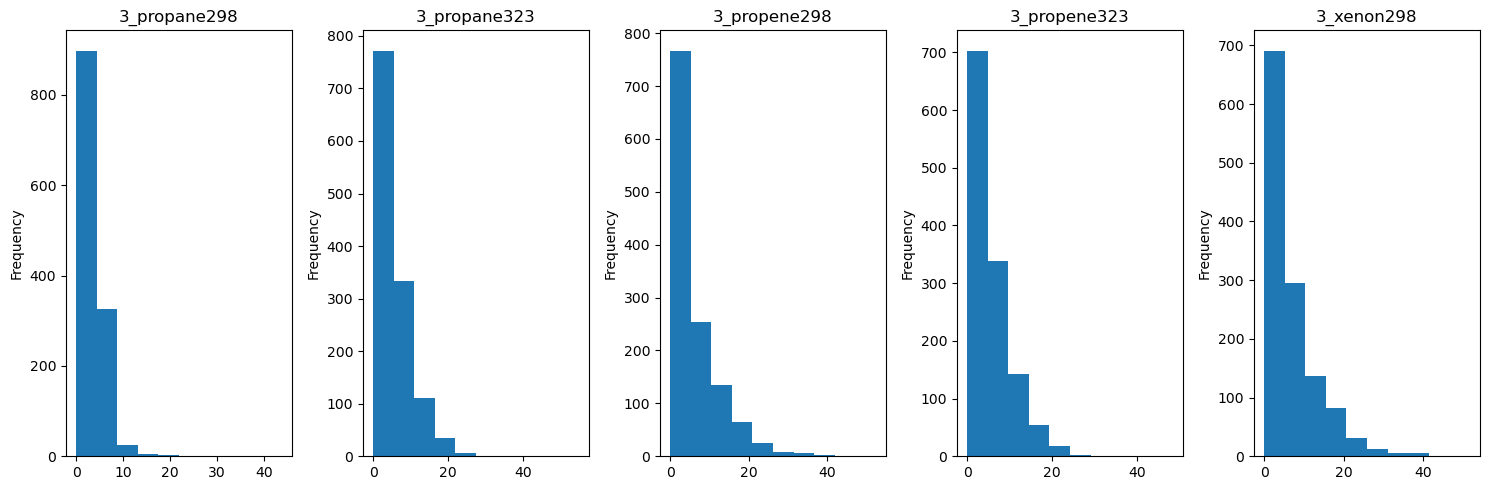

In [10]:
df = matriz_incompleta.drop(columns='Adsorbente')

# Crear histogramas para columnas en grupos de 10
num_columnas = len(df.columns)
grupo_tamanio = 5

for i in range(0, num_columnas, grupo_tamanio):
    grupo_columnas = df.columns[i:i + grupo_tamanio]
    
    # Crear subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(grupo_columnas), figsize=(15, 5))
    
    # Crear histogramas para cada columna en el grupo
    for j, column in enumerate(grupo_columnas):
        df[column].plot(kind='hist', ax=axes[j], bins=10, fontsize=10) # xlim=(min_value, max_value))
        axes[j].set_title(column, fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 2.2 Proceso de anulación de entradas aleatorias 

Como se mencionó al inicio, se anulará un porcentaje de las entradas de la matriz, es decir, se enviarán los valores a cero. Lo anterior con el objetivo de que el sistema propuesto complete dichas entradas, y una vez que se tenga listo, se cuente con los valores reales para poder evalúar el desempeño del modelo; a partir de una métrica real en conjunto con las métricas propias de la red neuronal. 

Se anula el 50% de las entradas de la matriz, de manera aleatoria.

In [11]:
#Para el proceso de anulación se omite la columna de adsorbentes, puesto que no es numérica
entradas_mat = matriz_incompleta.drop(['Adsorbente'],axis=1)
adsorbentes = matriz_incompleta['Adsorbente']

# Definir la fracción de entradas a convertir en cero
frac_to_zero = 0.5

# Obtener el número total de elementos en el DataFrame
total_elements = entradas_mat.size

# Calcular el número de elementos a convertir en cero
num_elements_to_zero = int(total_elements * frac_to_zero)

# Obtener una lista de índices aleatorios para los elementos a convertir en cero
np.random.seed(42)
random_indices = np.random.choice(total_elements, num_elements_to_zero, replace=False)

# Convertir los elementos en cero basados en los índices generados aleatoriamente
entradas_mat.values.flat[random_indices] = 0

In [12]:
random_indices

array([ 42159,  62953,   7217, ...,  34778, 113317,   4304])

In [13]:
#Una vez realizada la anulación, se añade nuevamente la columna de adsorbentes
entradas_mat.insert(0, 'Adsorbente', adsorbentes)
matriz_incompleta = entradas_mat
matriz_incompleta

,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,0.000000,0.844962,0.0,0.000000,0.301248,0.000000,0.000000,0.000000,...,0.000000,4.343379,3.062861,0.000000,27.645334,3.130662,0.000000,0.000000,0.000000,0.000000
1,"(15,15) SWSiCNT",0.000000,0.000000,0.460885,0.0,1.262480,0.000000,0.179975,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.459049,8.637432,0.000000,0.000000,2.344462,2.351026,0.000000
2,"(22,22) SWSiCNT",0.000000,3.040396,0.000000,0.0,15.397470,0.444007,0.000000,0.000000,0.000000,...,13.341930,0.000000,0.000000,6.373383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,(Cr)-MIL-101-SO3Ag,0.000000,0.000000,0.000000,0.0,0.000000,1.598743,0.976192,0.000000,0.000000,...,18.540556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.029259,24.667564,0.000000
4,(Cu(db)),5.991840,1.787435,0.000000,0.0,0.257570,0.000000,0.491625,0.290457,0.000000,...,4.647121,0.000000,2.697064,2.656299,0.000000,2.806321,0.000000,0.000000,0.000000,7.176484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,0.000000,0.597944,0.0,0.012183,0.474581,0.244710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.037405,0.000000,0.000000,6.944499
1257,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.800818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.257930
1258,{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,0.000000,0.000000,0.0,0.000000,0.000000,0.523100,0.000000,0.000000,...,0.000000,4.538204,0.000000,3.278202,24.443693,0.000000,0.000000,0.000000,1.959672,1.787560
1259,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},2.622934,0.000000,0.963068,0.0,2.947596,0.707617,0.000000,0.000000,0.101568,...,0.000000,0.000000,0.000000,2.589295,0.000000,0.000000,3.507734,0.000000,0.000000,2.186897


### Histograma después de la anulación de entradas

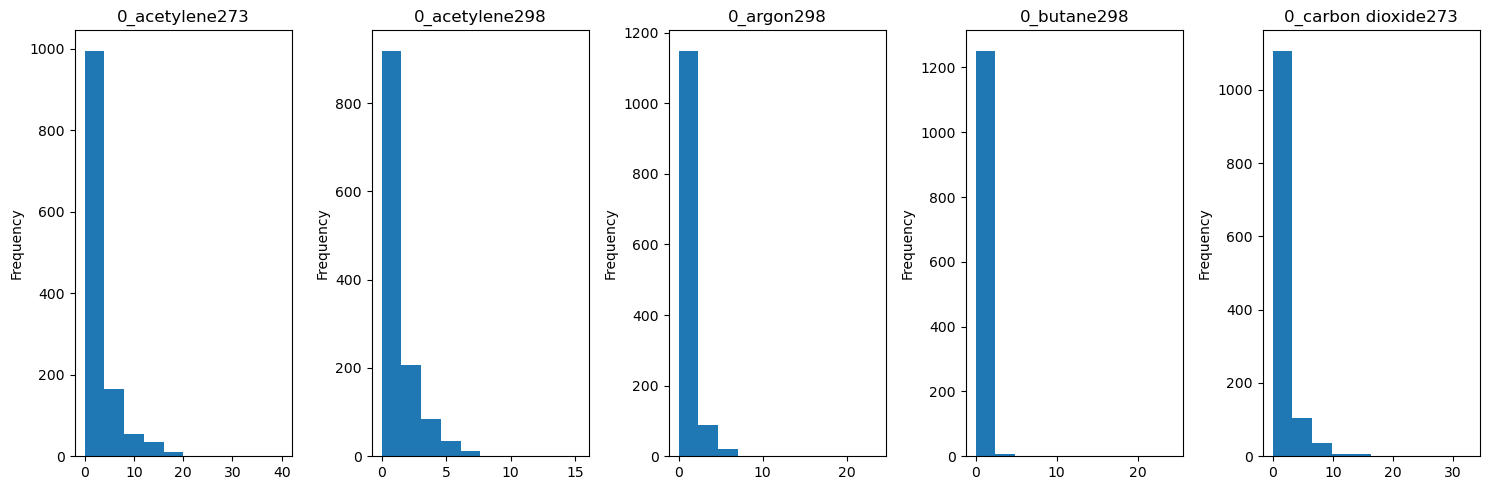

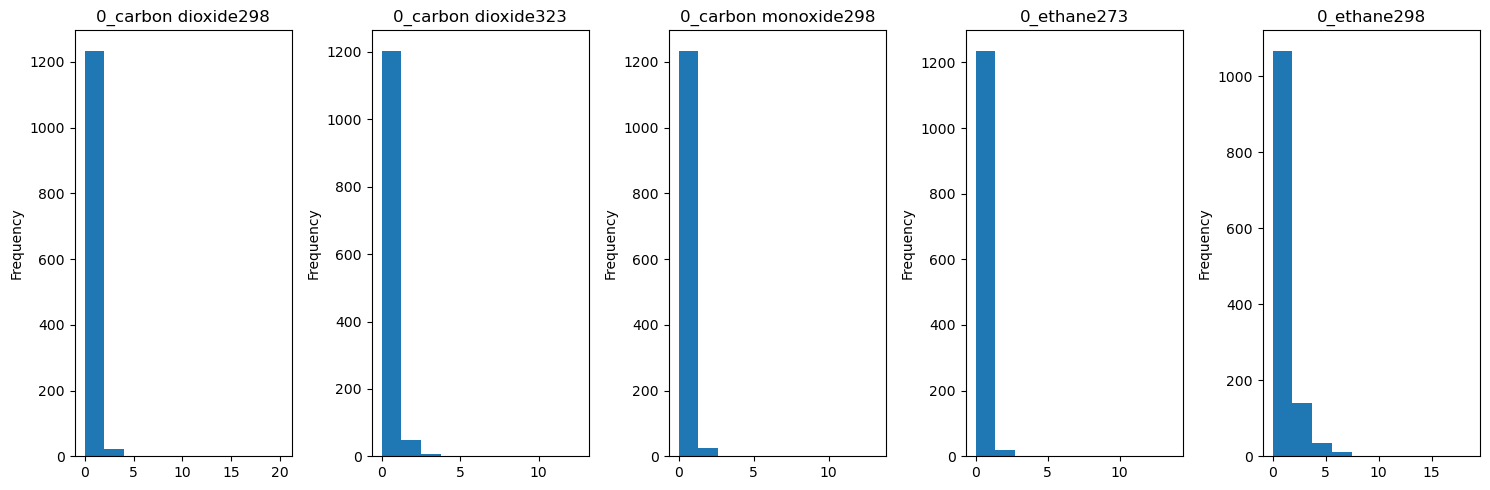

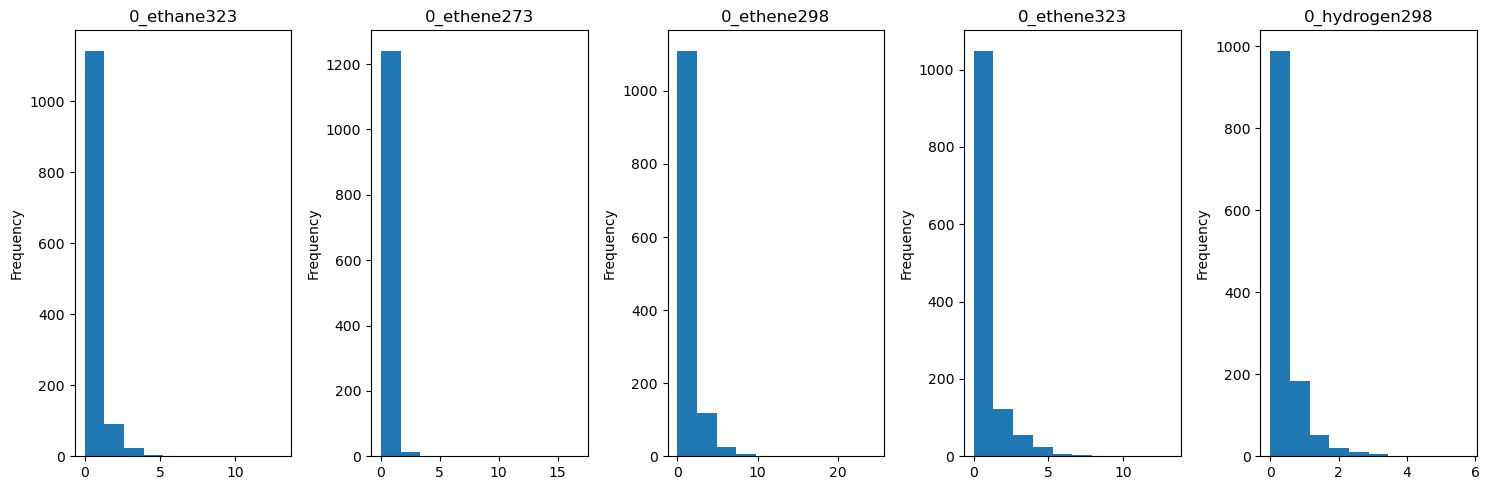

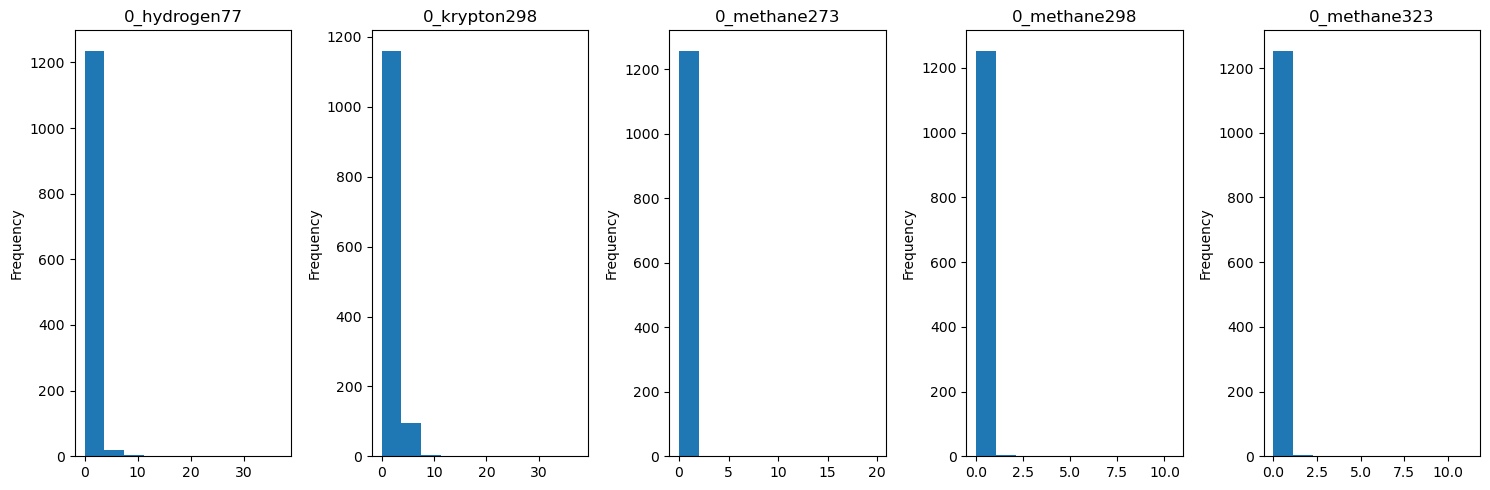

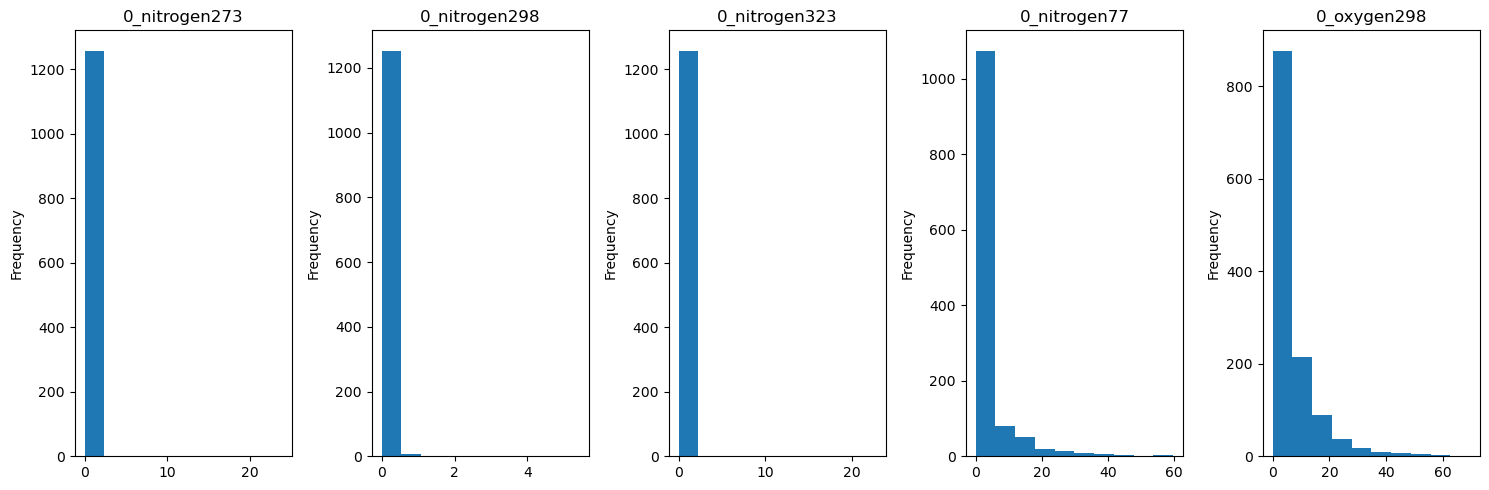

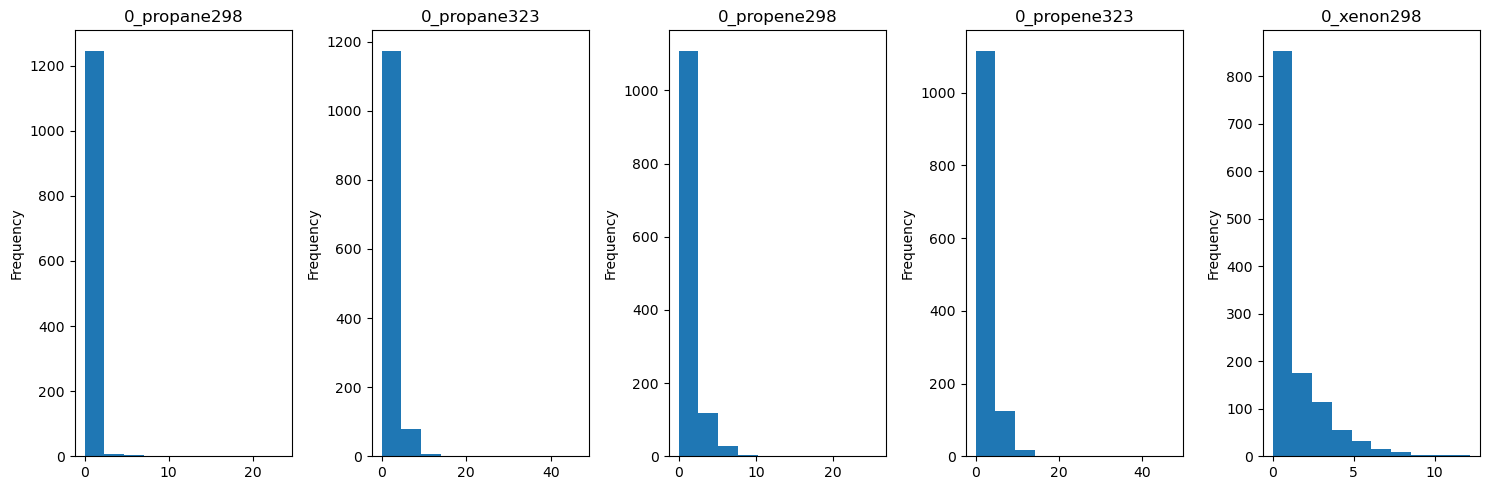

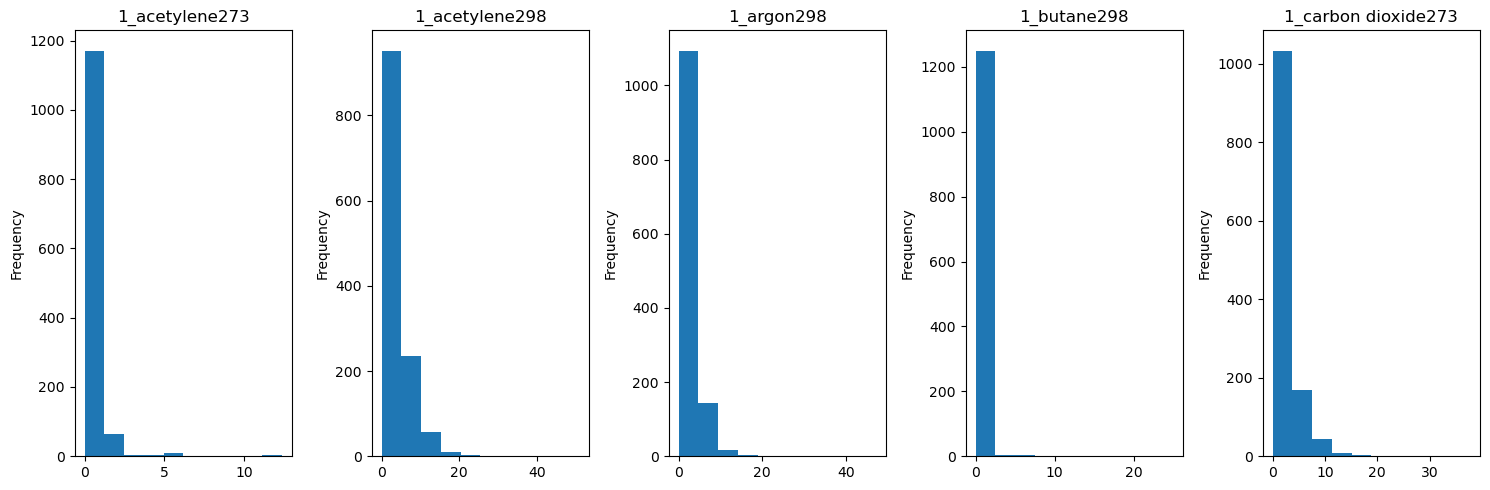

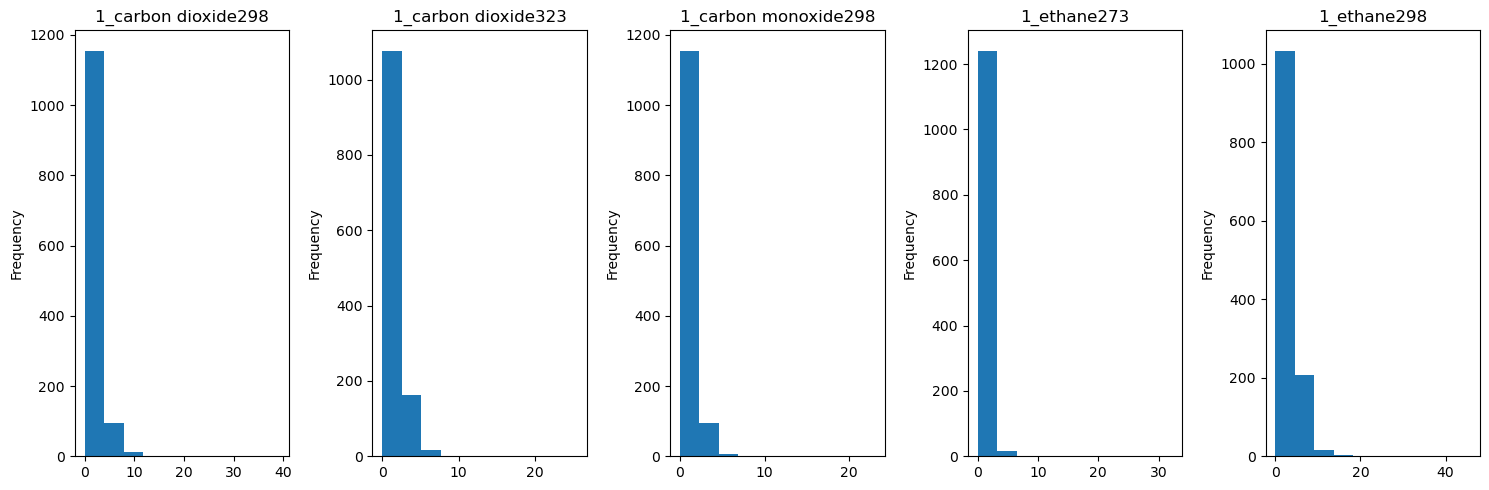

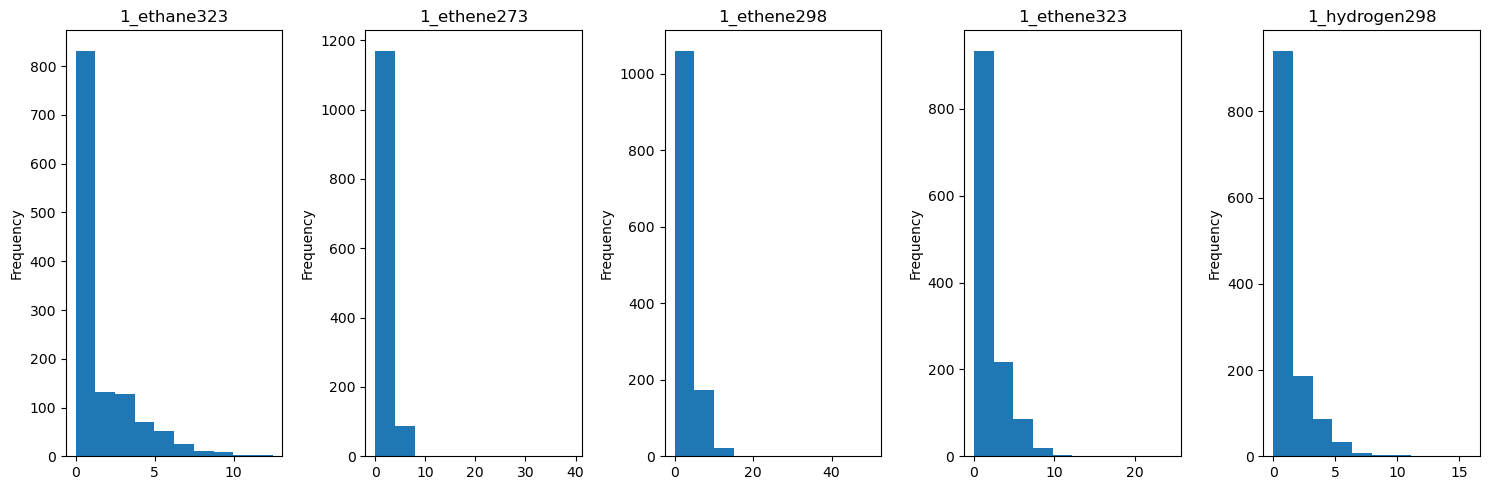

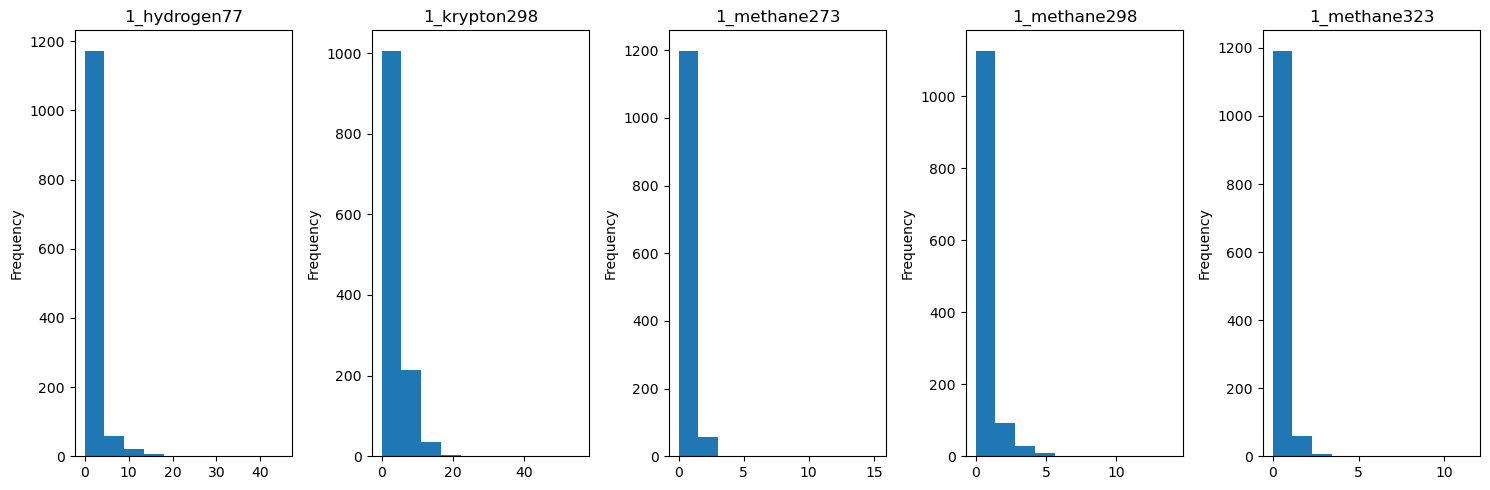

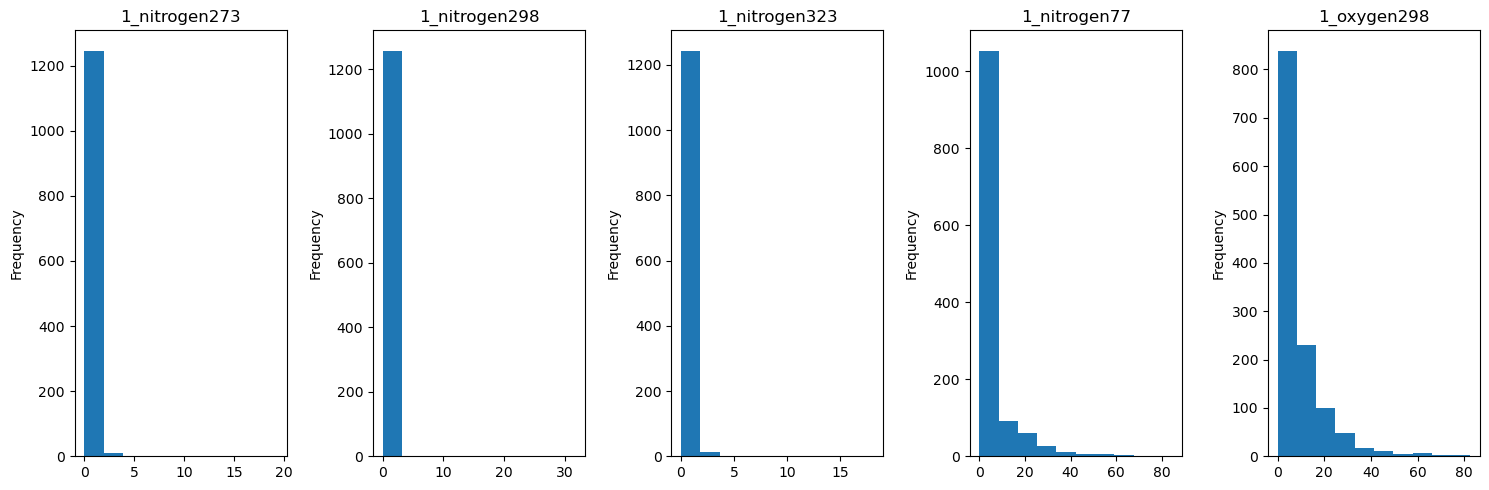

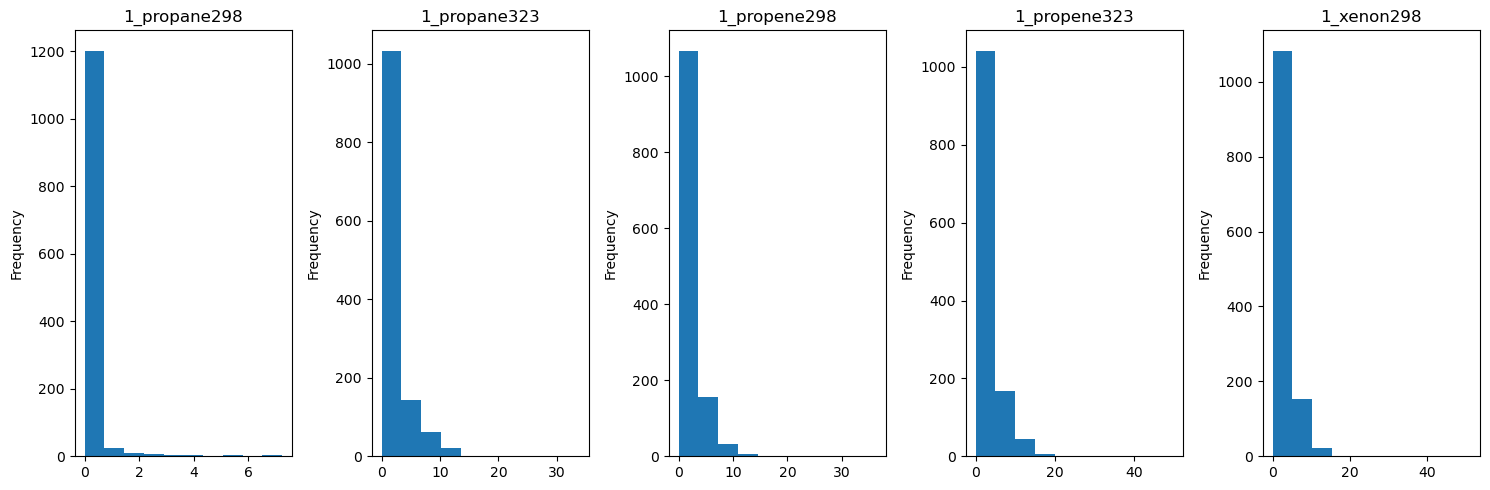

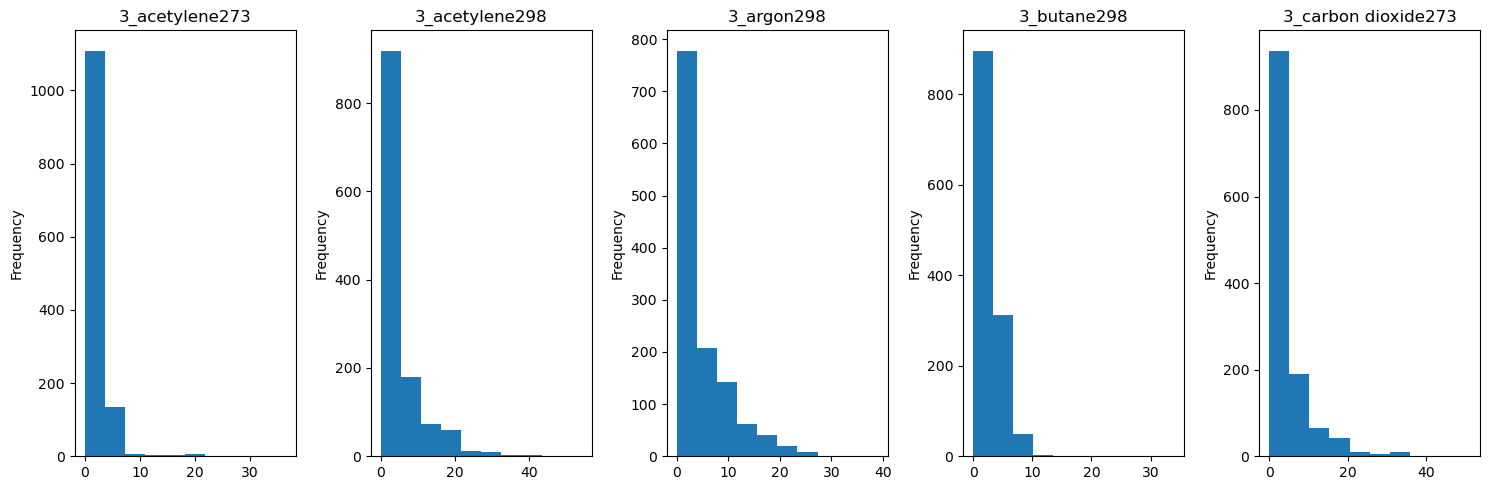

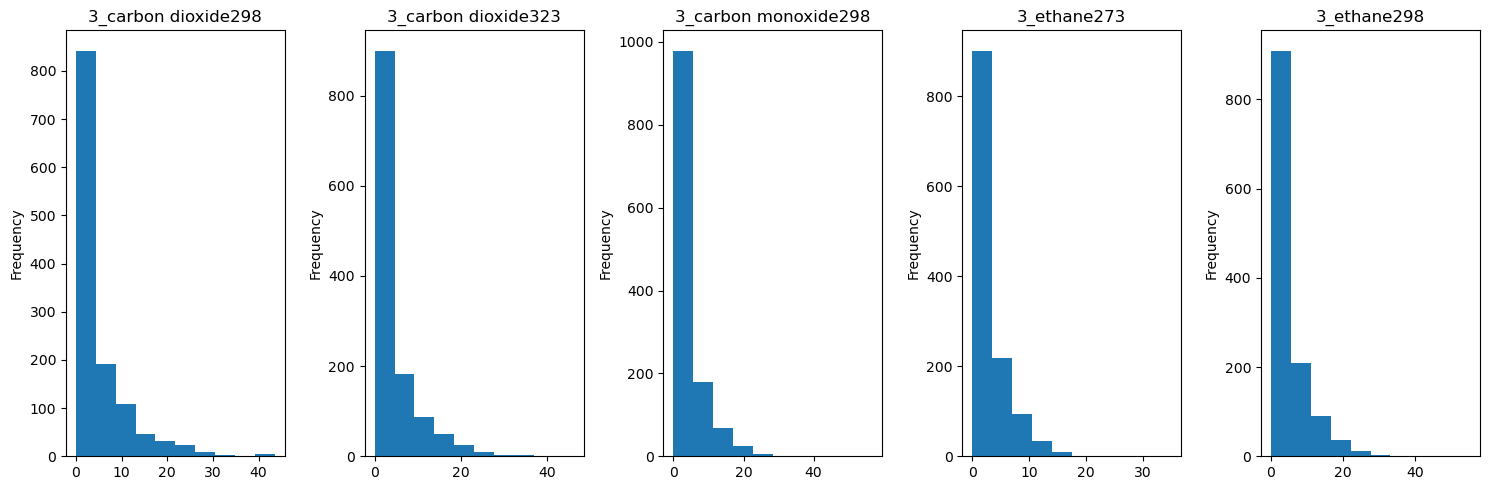

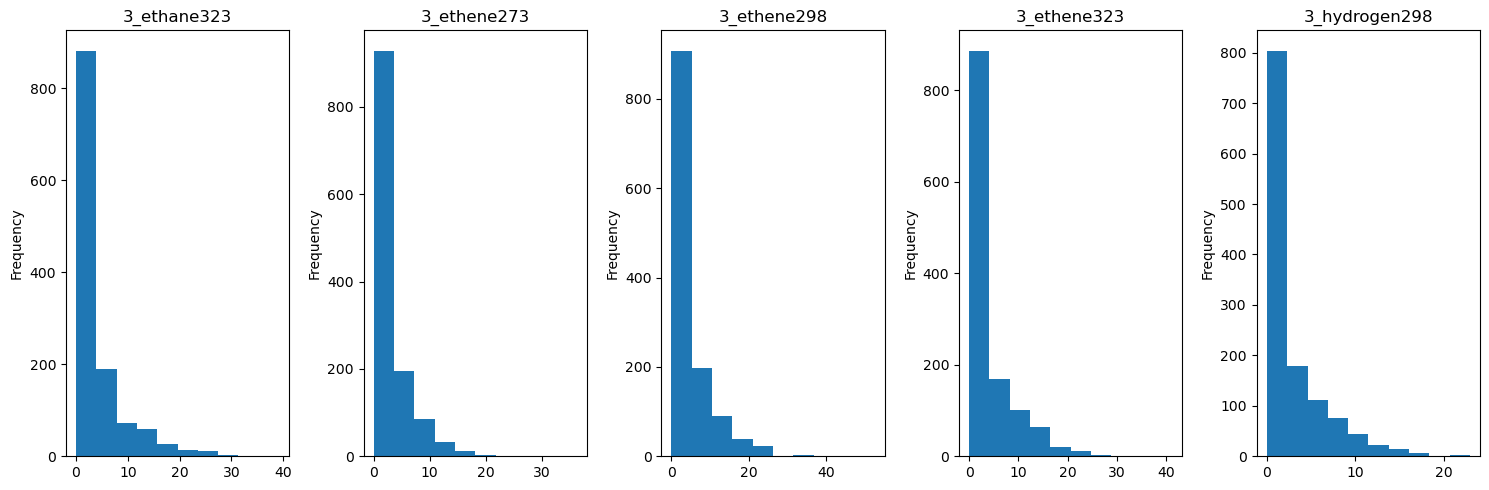

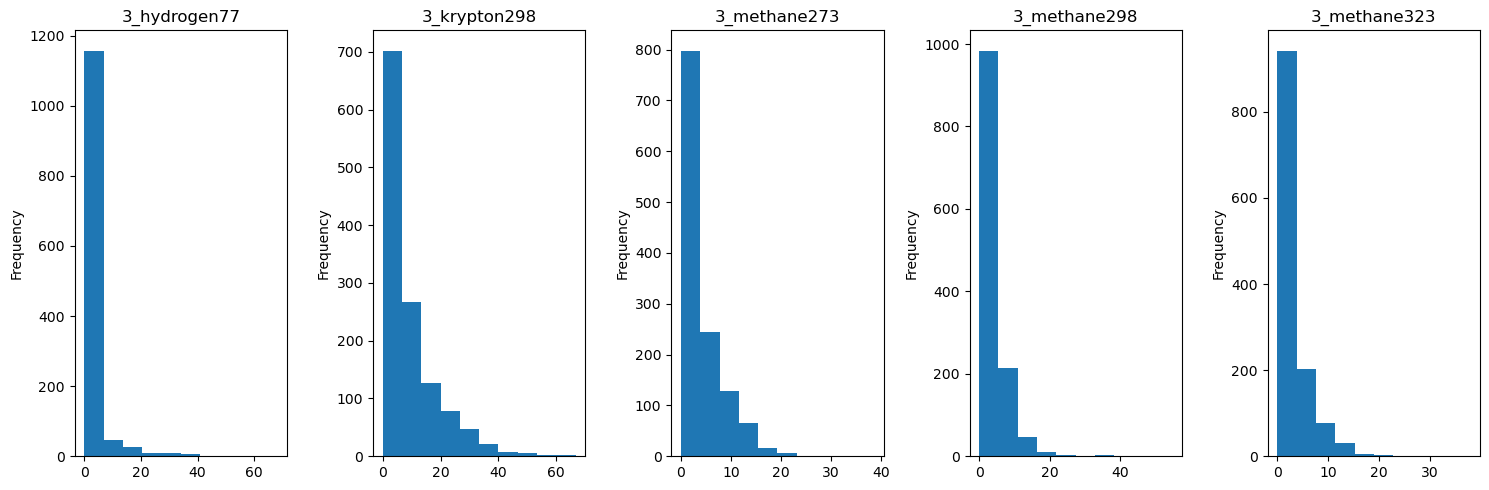

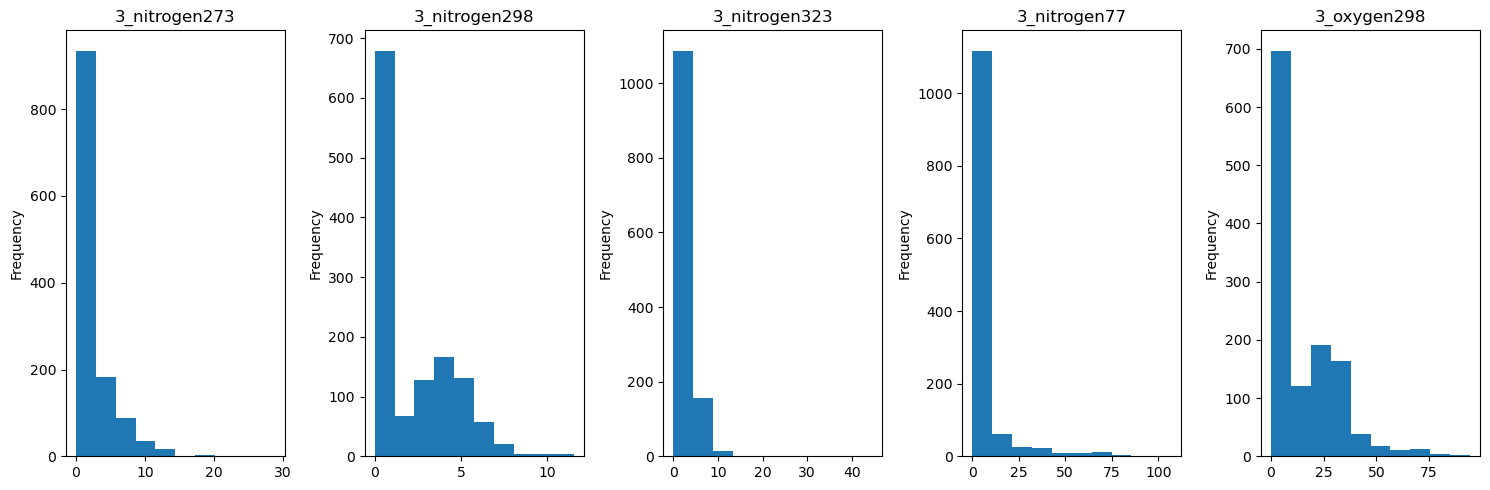

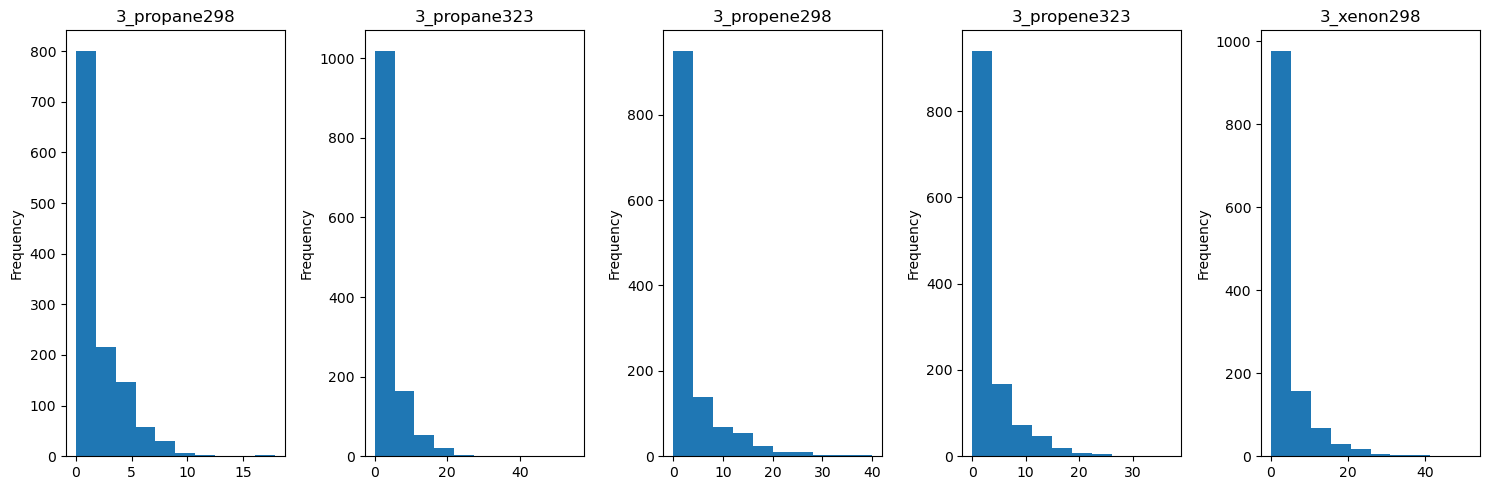

In [14]:
df = matriz_incompleta.drop(columns='Adsorbente')

# Crear histogramas para columnas en grupos de 10
num_columnas = len(df.columns)
grupo_tamanio = 5

for i in range(0, num_columnas, grupo_tamanio):
    grupo_columnas = df.columns[i:i + grupo_tamanio]
    
    # Crear subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(grupo_columnas), figsize=(15, 5))
    
    # Crear histogramas para cada columna en el grupo
    for j, column in enumerate(grupo_columnas):
        df[column].plot(kind='hist', ax=axes[j], bins=10, fontsize=10) # xlim=(min_value, max_value))
        axes[j].set_title(column, fontsize=12)
    
    plt.tight_layout()
    plt.show()

### Distribución de ceros en la matriz

Vamos a analizar la cantidad de ceros por columna, para asegurarnos que no se hayan generado patrones de ceros, o sesgos en la matriz; y se tenga una distribución uniforme de los mismos.

In [15]:
def conteo_ceros_columna(matriz):
    celdas_cero_por_columna = (matriz == 0).sum()
    return celdas_cero_por_columna

In [16]:
numero_de_ceros = list(conteo_ceros_columna(matriz_incompleta).values)
nombres_adsorbentes = list(conteo_ceros_columna(matriz_incompleta).keys())

In [17]:
conteo_ceros = pd.DataFrame({'Adsorbentes':nombres_adsorbentes, 'Cantidad de ceros':numero_de_ceros})
conteo_ceros = conteo_ceros[conteo_ceros['Adsorbentes']!='Adsorbente']
conteo_ceros

,Adsorbentes,Cantidad de ceros
1,0_acetylene273,626
2,0_acetylene298,655
3,0_argon298,625
4,0_butane298,1074
5,0_carbon dioxide273,655
...,...,...
86,3_propane298,627
87,3_propane323,622
88,3_propene298,657
89,3_propene323,666


In [18]:
np.mean(conteo_ceros['Cantidad de ceros'])

682.1777777777778

Text(0.5, 1.0, 'Histograma del número de ceros contenidos por columna')

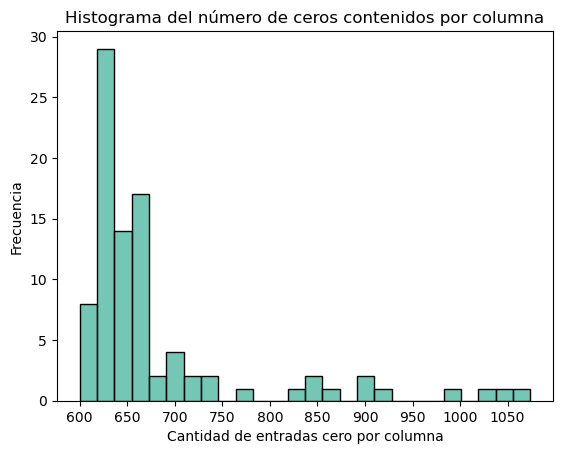

In [19]:
import seaborn as sn
sn.histplot(conteo_ceros['Cantidad de ceros'], color='#45B39D')
plt.xticks([600,650,700,750,800,850,900,950,1000,1050])
plt.xlabel('Cantidad de entradas cero por columna')
plt.ylabel('Frecuencia')
plt.title('Histograma del número de ceros contenidos por columna')

Una vez revisado lo anterior la matriz queda lista para prepararla para ingresar al modelo.

# Paso 3: Construcción de los conjuntos de entrenamiento y prueba

Para la división de los conjuntos de entrenamiento y prueba, se seccionará la matriz para tomar los últimos 100 adsorbentes como conjunto de prueba y el resto como conjunto de entrenamiento. No se realiza una revoltura aleatoria de los renglones antes de la separación puesto que se pretende mantener el mismo orden para poder comparar las predicciones con los valores originales directamente. 

In [20]:
#Seccionamiento de la matriz
matriz_train = matriz_incompleta.loc[0:1160]
matriz_test = matriz_incompleta.loc[1161:]

In [21]:
print(matriz_train.shape)
matriz_train.head()

(1161, 91)


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.03331,0.000000,0.844962,0.0,0.00000,0.301248,0.000000,0.000000,0.0,...,0.000000,4.343379,3.062861,0.000000,27.645334,3.130662,0.0,0.000000,0.000000,0.000000
1,"(15,15) SWSiCNT",0.00000,0.000000,0.460885,0.0,1.26248,0.000000,0.179975,0.000000,0.0,...,0.000000,0.000000,0.000000,1.459049,8.637432,0.000000,0.0,2.344462,2.351026,0.000000
2,"(22,22) SWSiCNT",0.00000,3.040396,0.000000,0.0,15.39747,0.444007,0.000000,0.000000,0.0,...,13.341930,0.000000,0.000000,6.373383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,(Cr)-MIL-101-SO3Ag,0.00000,0.000000,0.000000,0.0,0.00000,1.598743,0.976192,0.000000,0.0,...,18.540556,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.029259,24.667564,0.000000
4,(Cu(db)),5.99184,1.787435,0.000000,0.0,0.25757,0.000000,0.491625,0.290457,0.0,...,4.647121,0.000000,2.697064,2.656299,0.000000,2.806321,0.0,0.000000,0.000000,7.176484


In [22]:
print(matriz_test.shape)
matriz_test.head()

(100, 91)


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
1161,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.000000,0.947108,0.000000,0.0,0.0,0.061256,0.0,0.222439,0.00000,...,0.000000,0.000000,1.328918,12.008529,0.000000,1.433456,0.557101,0.600753,0.000000,0.000000
1162,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.029916,1.08621,...,11.867601,7.443300,0.000000,8.771895,0.000000,8.670429,15.977197,24.873333,0.000000,0.000000
1163,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,1.075090,0.784983,0.000000,0.0,0.0,0.712871,0.0,0.203600,1.00000,...,0.000000,4.699669,0.000000,3.052692,0.000000,0.000000,9.178073,8.817957,8.053491,9.396001
1164,[Zn2(CN5H2)3(H2O)3]6H2O,6.189885,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.590219,0.00000,...,0.684472,5.431553,4.832698,4.678391,25.974585,4.855744,0.000000,14.810995,0.000000,16.039534
1165,[Zn2(CN5H2)3(H2O)3]6H2O Ac,0.487708,0.000000,0.417787,0.0,0.0,0.000000,0.0,0.164744,0.00000,...,0.758638,2.966201,1.025537,1.067146,0.000000,0.000000,0.833559,1.440450,0.000000,2.190897


Finalmente, realizamos la preparación de ambos conjuntos para dejarlos en el formato adecuado:

In [23]:
train_dataset = matriz_train.pivot_table(index='Adsorbente')
test_dataset = matriz_test.pivot_table(index='Adsorbente')

In [24]:
train_dataset

,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,0_ethane298,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
Adsorbente,,,,,,,,,,,,,,,,,,,,,
((Me2NH2)In(NH2BDC)2),4.033310,0.000000,0.844962,0.000000,0.000000,0.301248,0.000000,0.000000,0.000000,0.983336,...,0.000000,4.343379,3.062861,0.000000,27.645334,3.130662,0.0,0.000000,0.000000,0.000000
"(15,15) SWSiCNT",0.000000,0.000000,0.460885,0.000000,1.262480,0.000000,0.179975,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.459049,8.637432,0.000000,0.0,2.344462,2.351026,0.000000
"(22,22) SWSiCNT",0.000000,3.040396,0.000000,0.000000,15.397470,0.444007,0.000000,0.000000,0.000000,1.457413,...,13.341930,0.000000,0.000000,6.373383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
(Cr)-MIL-101-SO3Ag,0.000000,0.000000,0.000000,0.000000,0.000000,1.598743,0.976192,0.000000,0.000000,0.260791,...,18.540556,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.029259,24.667564,0.000000
(Cu(db)),5.991840,1.787435,0.000000,0.000000,0.257570,0.000000,0.491625,0.290457,0.000000,0.000000,...,4.647121,0.000000,2.697064,2.656299,0.000000,2.806321,0.0,0.000000,0.000000,7.176484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[Zn(L)].4DMF-a,0.000000,2.736218,1.628760,0.048694,0.000000,0.000000,0.000000,0.000000,0.218797,2.451657,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.594571,0.0,1.046905,2.437513,0.000000
[Zn(SiF6)(pyz)2]n,6.960437,3.025187,1.658243,0.000000,0.000000,0.870614,0.465319,0.269397,0.000000,0.000000,...,5.735359,5.418282,4.886020,0.000000,25.311312,4.926080,0.0,17.616823,0.000000,18.987165
[Zn(bdc)(ted)0.5]*2DMF*0.2H2O,0.000000,0.000000,0.371280,0.000000,0.483421,0.432415,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.632395,0.000000,0.000000,23.199619,7.431206,0.0,0.111912,0.000000,0.000000


In [25]:
test_dataset

,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,0_ethane298,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
Adsorbente,,,,,,,,,,,,,,,,,,,,,
[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.000000,0.947108,0.000000,0.0,0.000000,0.061256,0.00000,0.222439,0.000000,0.000000,...,0.000000,0.000000,1.328918,12.008529,0.000000,1.433456,0.557101,0.600753,0.000000,0.000000
[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,2.029916,1.086210,0.000000,...,11.867601,7.443300,0.000000,8.771895,0.000000,8.670429,15.977197,24.873333,0.000000,0.000000
[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,1.075090,0.784983,0.000000,0.0,0.000000,0.712871,0.00000,0.203600,1.000000,0.000000,...,0.000000,4.699669,0.000000,3.052692,0.000000,0.000000,9.178073,8.817957,8.053491,9.396001
[Zn2(CN5H2)3(H2O)3]6H2O,6.189885,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.590219,0.000000,1.969778,...,0.684472,5.431553,4.832698,4.678391,25.974585,4.855744,0.000000,14.810995,0.000000,16.039534
[Zn2(CN5H2)3(H2O)3]6H2O Ac,0.487708,0.000000,0.417787,0.0,0.000000,0.000000,0.00000,0.164744,0.000000,0.528297,...,0.758638,2.966201,1.025537,1.067146,0.000000,0.000000,0.833559,1.440450,0.000000,2.190897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,0.000000,0.597944,0.0,0.012183,0.474581,0.24471,0.000000,0.000000,0.755804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.037405,0.000000,0.000000,6.944499
{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.800818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.257930
{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,0.000000,0.000000,0.0,0.000000,0.000000,0.52310,0.000000,0.000000,1.808458,...,0.000000,4.538204,0.000000,3.278202,24.443693,0.000000,0.000000,0.000000,1.959672,1.787560


Y guardamos como csv:

In [26]:
train_dataset.to_csv("train_50porciento_random.csv")
test_dataset.to_csv("test_50porciento_random.csv")

# Paso 4: Construcción de Clases

Se utilizará `Pytorch` como framework para las clases y objetos. 

A partir de esta sección, se puede ejecutar directamente sin necesidad de correr las secciones anteriores.

In [27]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import seaborn as sns 

Antes de iniciar con la implementación de las clases, es necesario definir una variable que indique el número de GPU a utilizar, esto con el fin de no tener que cambiarlo en cada línea cada vez que se necesite.   

In [28]:
num_gpu = 2

Las clases que se construyen a continuación se utilizan para cargar los conjuntos de datos en el formato requerido para `Pytorch` a partir de los archivos `CSV` generados en los pasos anteriores (de prueba y entrenamiento respectivamente). El constructor de la clase toma el nombre del archivo CSV y una función de transformación opcional como argumentos. La función de transformación se aplica a los datos del archivo CSV. Si no se proporciona ninguna función de transformación, los datos se devuelven sin cambios.

## TestDataset


In [29]:
# Definir la clase TestDataset
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        # Cargar los datos del archivo CSV y elimina la primera columna (Adsorbente)
        #Al final los datos a completar se encuentran en las columnas de las propiedades y no en la que contiene la información de los adsorbentes
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        # Aplicar la función de transformación si se proporciona
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        # Devolver la longitud del conjunto de datos de prueba
        return len(self.data[0])
    
    def __getitem__(self, ind):
        # Devolver el vector de adsorbente correspondiente al índice especificado
        user_vector = self.data.data[0][ind]
        return user_vector

## TrainDataset

In [30]:
# Definir la clase TrainDataset
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        # Cargar los datos del archivo CSV y elimina la primera columna (Adsorbente)
        #Al final los datos a completar se encuentran en las columnas de las propiedades y no en la que contiene la información de los adsorbentes
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        # Aplicar la función de transformación si se proporciona
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        # Devolver la longitud del conjunto de datos de entrenamiento
        return len(self.data[0])
    
    def __getitem__(self, ind):
        # Devolver el vector de adsorbente correspondiente al índice especificado
        user_vector = self.data.data[0][ind]
        return user_vector

## Loss Function

In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable

Definimos ahora otra clase llamada MSEloss_with_Mask, la cual calcula la función de pérdida Mean Squared Error (MSE) para el modelo de filtrado colaborativo, considerando que algunas entradas están enmascaradas. En un modelo de filtrado colaborativo, las entradas enmascaradas se refieren a los elementos del conjunto de datos que se han ocultado o eliminado temporalmente para evaluar el rendimiento del modelo. Este enmascaramiento es aplicado puesto que no tiene sentido calcular la pérdida para las entradas cero de la matriz, pues generaría un sesgo en el proceso de entrenamiento.  

In [32]:
class MSEloss_with_Mask(nn.Module):
  #Esta clase hereda de la clase nn.Module de PyTorch
  def __init__(self):
    super(MSEloss_with_Mask,self).__init__()

  def forward(self,inputs, targets):
    #inputs, targets - entradas y salidas del modelo respectivamente 
    # Enmascaramiento en un vector de 1's y 0's.
    mask = (targets!=0)
    mask = mask.float()

    # Número real de datos en la matriz.
    # Se toma el máximo para evitar la división por cero en el cálculo de la pérdida.
    other = torch.Tensor([1.0])
    other = other.cuda(num_gpu)
    number_ratings = torch.max(torch.sum(mask),other)

    # Cálculo del error cuadrático medio (MSE) y la pérdida
    error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
    loss = error.div(number_ratings)

    return loss[0]

### RMSE

La función de pérdida calcula el MMSE (Mask Mean Square Error), sin embargo, definiremos también una función que calcule el RMSE como métrica de evaluación al desempeño del modelo. El RMSE corresponde a la raíz cuadrada del MMSE. 

In [33]:
def calcular_rmse(mmse):
    rmse = np.sqrt(mmse)
    return rmse 
    

## Modelo Autoencoder

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

Un autoencoder es una red neuronal que tiene como objetivo aprender una representación latente de los datos de entrada, de tal manera que se puedan reconstruir los datos originales a partir de dicha representación. Este proceso, permite completar los valores faltantes en los datos originales. 

<div>
<img src="/home/celeste/tesis/recommender/Recommender-NVIDIA/imagenes_notebook/autoencoder.jpg" width='600'/>
</div>

Definición de la función de activación:

In [35]:
def activation(input, type):
  
    if type.lower()=='selu':
        return F.selu(input)
    elif type.lower()=='elu':
        return F.elu(input)
    elif type.lower()=='relu':
        return F.relu(input)
    elif type.lower()=='relu6':
        return F.relu6(input)
    elif type.lower()=='lrelu':
        return F.leaky_relu(input)
    elif type.lower()=='tanh':
        return F.tanh(input)
    elif type.lower()=='sigmoid':
        return F.sigmoid(input)
    elif type.lower()=='swish':
        return F.sigmoid(input)*input
    elif type.lower()=='identity':
        return input
    else:
        raise ValueError("Unknown non-Linearity Type")

In [36]:
funciones_activation = ['selu', 'elu', 'relu', 'relu6', 'lrelu', 'tanh', 'sigmoid', 'swish', 'identity']

Construcción de la clase AutoEncoder:

In [37]:
class AutoEncoder(nn.Module):
    # Constructor de la clase, recibe como parámetros layer_sizes, nl_type, is_constrained, dp_drop_prob y last_layer_activations
    def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):
        """
        layer_sizes = tamaño de cada capa en el modelo de encoder. Should start with feature size (e.g. dimensionality of x)
        Por ejemplo: [10000, 1024, 512] resultará en:
            - 2 capas de encoder: 10000x1024 y 1024x512. La capa de representación (z) será de 512.
            - 2 capas de decoder: 512x1024 y 1024x10000.
    
        nl_type = tipo de no linealidad (por defecto: 'selu').
        is_constrained = Si es verdadero, entonces los pesos del encoder y decoder están atados.
        dp_drop_prob = probabilidad de Dropout.
        last_layer_activations = Si es verdadero, se aplica una activación en la última capa del decoder.
        """

        # Llama al constructor de la clase padre (nn.Module)
        super(AutoEncoder, self).__init__()

        # Asignación de parámetros a variables de la instancia
        self.layer_sizes = layer_sizes
        self.nl_type = nl_type
        self.is_constrained = is_constrained
        self.dp_drop_prob = dp_drop_prob
        self.last_layer_activations = last_layer_activations

        # Si dp_drop_prob > 0, se inicializa una instancia de Dropout
        if dp_drop_prob>0:
            self.drop = nn.Dropout(dp_drop_prob)

        self._last = len(layer_sizes) - 2

        # Inicialización de pesos del encoder
        self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

        # "Inicialización Xavier" (Entendiendo la dificultad en entrenar redes neuronales profundas de alimentación directa - por Glorot, X. & Bengio, Y.)
        # (Los valores se muestrean a partir de una distribución uniforme)
        for weights in self.encoder_weights:
            init.xavier_uniform_(weights)

        # Bias del encoder
        self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

        # Lista de layer_sizes invertida
        reverse_layer_sizes = list(reversed(layer_sizes)) 
        # reversed retorna un iterador

        # Inicialización de pesos del decoder si is_constrained es falso
        if is_constrained == False:
            self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

            # Inicialización Xavier de los pesos del decoder
            for weights in self.decoder_weights:
                init.xavier_uniform_(weights)

        # Bias del decoder
        self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] ) 
    
    
    def encode(self, x):
     #Realiza la codificación de la entrada x'
     # Recorremos la lista de pesos del codificador
        for i, w in enumerate(self.encoder_weights):
            # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del codificador, y sumamos el sesgo correspondiente
            x = F.linear(input=x, weight=w, bias=self.encoder_bias[i])
            # Aplicamos la función de activación correspondiente al tipo de no linealidad definida
            x = activation(input=x, type=self.nl_type)

        # Aplicamos Dropout en la última capa, si se define una probabilidad de eliminación de nodos
        if self.dp_drop_prob > 0:
            x = self.drop(x)

    # Retornamos el tensor resultante
        return x
    
    def build_latent_rep(self,x):
        #Obtiene la representación latente de nuevos datos una vez que el encoder ya está entrenado
        self.eval()
        x=self.encode(x)
        #será necesario agregar el paso de x = x.detach().numpy()?
        return x 


    def decode(self, x):
        # Si se trata de un modelo con pesos atados, se aplica la operación de decodificación con los pesos del codificador invertidos
        if self.is_constrained == True:
            # Los pesos están atados, por lo que recorremos los pesos del codificador en orden inverso
            for i, w in zip(range(len(self.encoder_weights)), list(reversed(self.encoder_weights))):
                # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del decodificador, y sumamos el sesgo correspondiente
                x = F.linear(input=x, weight=w.t(), bias=self.decoder_bias[i])
                # Aplicamos la función de activación correspondiente al tipo de no linealidad definida, excepto para la última capa si se define que no tenga activación
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        else:
            # Los pesos no están atados, por lo que recorremos los pesos del decodificador
            for i, w in enumerate(self.decoder_weights):
                # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del decodificador, y sumamos el sesgo correspondiente
                x = F.linear(input=x, weight=w, bias=self.decoder_bias[i])
                # Aplicamos la función de activación correspondiente al tipo de no linealidad definida, excepto para la última capa si se define que no tenga activación
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

    # Retornamos el tensor resultante
        return x


    def forward(self, x):
        return self.decode(self.encode(x))

### Función que ejecuta la preparación de nuevos datos a partir de las clases anteriores

In [38]:
def prepare_newdata(ruta_datos, batch_size, num_workers=0):
    #preparar los datos para poder ingresarlos al modelo
    transformations = transforms.Compose([transforms.ToTensor()])
    test_dat = TestDataset(ruta_datos, transformations)
    test_dl = DataLoader(dataset=test_dat, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return test_dl
    

# Paso 5: Definición de funciones `train` y `predict`

In [39]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from livelossplot import PlotLosses

Definición de una función que nos permitirá realizar el proceso de entrenamiento del modelo. 


In [40]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
  # Definimos la función "train" que toma como entrada un modelo, un criterio de pérdida, un optimizador, 
  # un conjunto de entrenamiento y un conjunto de pruebas, y un número de épocas.

  # Inicializamos la biblioteca livelossplot para graficar en tiempo real la pérdida de entrenamiento y validación
  liveloss = PlotLosses()
  
  #Listas de pérdidas de entrenamiento y validación
  lr_tr_loss = []
  lr_val_loss= []
  
  # Iteramos sobre cada época
  for epoch in range(num_epochs):
    
    #Matrices completas
    matrix_out_train = torch.Tensor([])
    matrix_out_test = torch.Tensor([])
    
    # Creamos dos listas vacías para guardar la pérdida de entrenamiento y la de validación en cada época
    train_loss, valid_loss = [], []
    
    # Creamos un diccionario vacío para guardar los registros de la pérdida en la biblioteca livelossplot
    logs = {}
    
    # Definimos un prefijo para los registros (en este caso, vacío)
    prefix = ''

    # Entrenamiento
    # Ponemos el modelo en modo de entrenamiento
    model.train()
    
    # Iteramos sobre los datos en el conjunto de entrenamiento
    for i, data in enumerate(train_dl, 0):
      # Obtenemos los datos de entrada y las etiquetas
      inputs = labels = data
      
      # Enviamos los datos a la GPU si está disponible
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertimos los datos en tensores flotantes
      inputs = inputs.float() 
      labels = labels.float()

      # Ponemos los gradientes en cero
      optimizer.zero_grad()

      # Se aplica la función forward a inputs 
      outputs = model(inputs)
      
      # Enviamos la salida del modelo a la GPU si está disponible
      outputs = outputs.cuda(num_gpu)
      
      # Calculamos la pérdida
      loss = criterion(outputs,labels)
      
      # Realizamos el retroceso
      loss.backward()
      
      # Actualizamos los pesos
      optimizer.step()

      # -> Re-alimentación densa iterativa de salida <- #
      
      # Ponemos los gradientes en cero
      optimizer.zero_grad()
      
      # Es importante "detach()" la salida para evitar la construcción innecesaria del grafo computacional
      outputs = model(outputs.detach()) 
      #revisar si la salida del modelo está en cpu
      
      # Enviamos la salida a la GPU si está disponible
      outputs = outputs.cuda(num_gpu)
      
      # Calculamos la pérdida
      loss = criterion(outputs, labels)
      
      # Realizamos el retroceso
      loss.backward()
      
      # Actualizamos los pesos
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en la lista "train_loss"
      train_loss.append(loss.item())
      
      # Guardamos la pérdida en el diccionario de registros
      logs[prefix + 'MMSE loss'] = loss.item()
      
      outputs = outputs.to('cpu')
      #Guardamos el batch reconstruido de entrenamiento
      matrix_out_train = torch.cat([matrix_out_train, outputs], 0)
      
      # Iterar a través de los datos de test_dl utilizando el índice i comenzando desde 0.
    for i, data in enumerate(test_dl, 0):
      # Establecer el modelo en modo de evaluación.
      model.eval()
      # Asignar los datos a las variables inputs y labels.
      inputs = labels = data
      # Mover las variables inputs y labels a la GPU si está disponible.
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertir las variables inputs y labels a float.
      inputs = inputs.float()
      labels = labels.float()

      # Calcular las predicciones utilizando el modelo con las variables inputs.
      outputs = model(inputs)
      # Mover las predicciones a la GPU si está disponible.
      outputs = outputs.cuda(num_gpu)
      # Calcular la pérdida utilizando las predicciones y las etiquetas.
      loss = criterion(outputs, labels)

      # Agregar la pérdida a la lista de pérdidas de validación.
      valid_loss.append(loss.item())
      # Establecer el prefijo como 'val_'
      prefix = 'val_'
      # Agregar la pérdida a los registros con el prefijo.
      logs[prefix + 'MMSE loss'] = loss.item()
      
      #Guardamos el batch reconstruido de entrenamiento
      outputs = outputs.to('cpu')
      matrix_out_test = torch.cat([matrix_out_test, outputs], 0)

    # Calcular la media de las pérdidas de entrenamiento y agregarla a la lista de pérdidas de entrenamiento.
    lr_tr_loss.append(np.mean(train_loss))
    # Calcular la media de las pérdidas de validación y agregarla a la lista de pérdidas de validación.
    lr_val_loss.append(np.mean(valid_loss))
    # Actualizar los registros utilizando la librería liveloss.
    liveloss.update(logs)
    # Dibujar el gráfico utilizando la librería liveloss.
    #liveloss.draw()
    liveloss.send()

    # Imprimir el número de la época actual y la pérdida de entrenamiento y validación promedio.
    print("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
    
    # Si la época actual es la última, devolver las predicciones.
    if epoch == num_epochs -1:
      return matrix_out_train, matrix_out_test, lr_tr_loss, lr_val_loss

Las listas `lr_tr_loss` y `lr_val_loss` contienen los valores de la pérdida a lo largo del entrenamiento (el promedio para cada época). Nos servirán para poder graficar el comportamiento de dicha pérdida incluso después de haber realizado el entrenamiento. El último valor contenido en cada lista, corresponderá a la pérdida asociada al final del entrenamiento, y será a este valor al que se le calculará el RMSE posteriormente. 

Función para realizar predicciones cuando lleguen nuevos datos:

In [41]:
def predict(model, criterion, test_dl):
    lr_val_loss= []
    matrix_out_test = torch.Tensor([])
    valid_loss = []
    
    # Iterar a través de los batches de los datos utilizando el índice i comenzando desde 0.
    for i, data in enumerate(test_dl, 0):
      # Establecer el modelo en modo de evaluación.
      model.eval()
      # Asignar los datos a las variables inputs y labels.
      inputs = labels = data
      # Mover las variables inputs y labels a la GPU si está disponible.
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertir las variables inputs y labels a float.
      inputs = inputs.float()
      labels = labels.float()

      # Calcular las predicciones utilizando el modelo con las variables inputs.
      outputs = model(inputs)
      # Mover las predicciones a la GPU si está disponible.
      outputs = outputs.cuda(num_gpu)
      # Calcular la pérdida utilizando las predicciones y las etiquetas.
      loss = criterion(outputs, labels)

      # Agregar la pérdida a la lista de pérdidas de validación.
      valid_loss.append(loss.item())
      
      #Guardamos el batch reconstruido de entrenamiento
      outputs = outputs.to('cpu')
      #Vamos concatenando los batches para recuperar la matriz original
      matrix_out_test = torch.cat([matrix_out_test, outputs], 0)
    
    # Imprimir el número de la época actual y la pérdida promedio para todos los batches. 
    print("Loss (MMSE): ", np.mean(valid_loss))
    print('Matrix shape: ', matrix_out_test.shape)
    print('RMSE: ', np.sqrt(np.mean(valid_loss))) #debe ser el último valor o el promedio?
    
    return matrix_out_test
    

# Paso 6: Implementación 

Una vez que hemos construido todo lo anterior, estamos listos para implementarlo y construir el modelo de interés. 

In [42]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

## 6.1 Datos 

### Importación de la matriz original completa:

In [43]:
matriz_completa = pd.read_excel('/home/celeste/tesis/recommender/Recommender-Adsorbentes/datos/Complete_matrix.xlsx')

### Importación de los conjuntos de entrenamiento y prueba:

In [44]:
train_original = pd.read_csv('/home/celeste/tesis/recommender/Recommender-Adsorbentes/train_50porciento_random.csv')
test_original = pd.read_csv('/home/celeste/tesis/recommender/Recommender-Adsorbentes/test_50porciento_random.csv')

print(train_original.shape)
print(test_original.shape)

(1161, 91)
(100, 91)


In [45]:
train_original.head()

,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.03331,0.000000,0.844962,0.0,0.00000,0.301248,0.000000,0.000000,0.0,...,0.000000,4.343379,3.062861,0.000000,27.645334,3.130662,0.0,0.000000,0.000000,0.000000
1,"(15,15) SWSiCNT",0.00000,0.000000,0.460885,0.0,1.26248,0.000000,0.179975,0.000000,0.0,...,0.000000,0.000000,0.000000,1.459049,8.637432,0.000000,0.0,2.344462,2.351026,0.000000
2,"(22,22) SWSiCNT",0.00000,3.040396,0.000000,0.0,15.39747,0.444007,0.000000,0.000000,0.0,...,13.341930,0.000000,0.000000,6.373383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,(Cr)-MIL-101-SO3Ag,0.00000,0.000000,0.000000,0.0,0.00000,1.598743,0.976192,0.000000,0.0,...,18.540556,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.029259,24.667564,0.000000
4,(Cu(db)),5.99184,1.787435,0.000000,0.0,0.25757,0.000000,0.491625,0.290457,0.0,...,4.647121,0.000000,2.697064,2.656299,0.000000,2.806321,0.0,0.000000,0.000000,7.176484


In [46]:
test_original.head()

,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.000000,0.947108,0.000000,0.0,0.0,0.061256,0.0,0.222439,0.00000,...,0.000000,0.000000,1.328918,12.008529,0.000000,1.433456,0.557101,0.600753,0.000000,0.000000
1,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.029916,1.08621,...,11.867601,7.443300,0.000000,8.771895,0.000000,8.670429,15.977197,24.873333,0.000000,0.000000
2,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,1.075090,0.784983,0.000000,0.0,0.0,0.712871,0.0,0.203600,1.00000,...,0.000000,4.699669,0.000000,3.052692,0.000000,0.000000,9.178073,8.817957,8.053491,9.396001
3,[Zn2(CN5H2)3(H2O)3]6H2O,6.189885,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.590219,0.00000,...,0.684472,5.431553,4.832698,4.678391,25.974585,4.855744,0.000000,14.810995,0.000000,16.039534
4,[Zn2(CN5H2)3(H2O)3]6H2O Ac,0.487708,0.000000,0.417787,0.0,0.0,0.000000,0.0,0.164744,0.00000,...,0.758638,2.966201,1.025537,1.067146,0.000000,0.000000,0.833559,1.440450,0.000000,2.190897


Preparación de los conjuntos de entrenamiento y prueba para ingresarse a la red:

In [47]:
transformations = transforms.Compose([transforms.ToTensor()])

In [48]:
train_dat = TrainDataset('/home/celeste/tesis/recommender/Recommender-Adsorbentes/train_50porciento_random.csv', transformations)

print("Training Length: ", train_dat.__len__())

Training Length:  1161


In [49]:
test_dat = TestDataset('/home/celeste/tesis/recommender/Recommender-Adsorbentes/test_50porciento_random.csv', transformations)

print("Testing Length: ", test_dat.__len__())

Testing Length:  100


### Dataloader



In [50]:
train_dl = DataLoader(dataset=train_dat, batch_size = 128, shuffle=False, num_workers = 0)


In [51]:
test_dl = DataLoader(dataset=test_dat, batch_size=8, shuffle=False, num_workers=0)


## 6.2 Modelo

El número de neuronas que debe tener la primera capa del modelo corresponde al `número de columnas` de la matriz de entrada.

In [52]:
#cantidad de neuronas por capa
layer_sizes = [90, 75, 75, 85]

Como buscamos una representación latente de los datos de entrada, conviene escoger como número de neuronas de las capas ocultas, una cantidad menor que las asociadas a la capa de entrada. 

In [53]:
#Definición del modelo
model = AutoEncoder(layer_sizes=layer_sizes, nl_type='relu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)
#movemos el modelo a la GPU
model = model.cuda(num_gpu)

La condición de `is constrained` disminuye notablemente los valores de pérdida. Esta condición forza la simetría en cuanto a estructura de capas de la red. Se opta por la función de activación `relu`. 

In [54]:
#Loss Function

criterion = MSEloss_with_Mask()
criterion = criterion.cuda(num_gpu)

In [55]:
#Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [56]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
encoder_weights.0 	 torch.Size([75, 90])
encoder_weights.1 	 torch.Size([75, 75])
encoder_weights.2 	 torch.Size([85, 75])
encoder_bias.0 	 torch.Size([75])
encoder_bias.1 	 torch.Size([75])
encoder_bias.2 	 torch.Size([85])
decoder_bias.0 	 torch.Size([75])
decoder_bias.1 	 torch.Size([75])
decoder_bias.2 	 torch.Size([90])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8]}]


Comprobemos que se está utilizando la gpu:

In [57]:
torch.cuda.is_available()

True

## 6.3 Ajuste del modelo

Procedemos a entrenar el modelo:

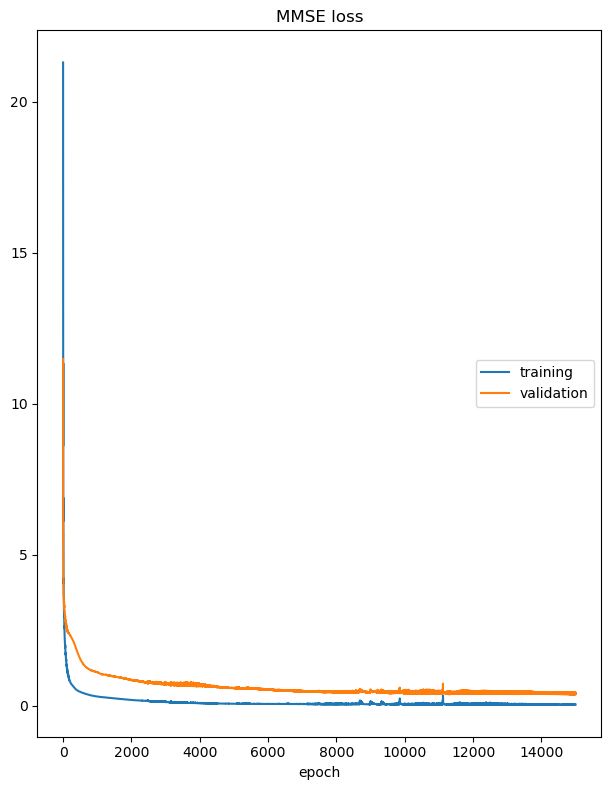

MMSE loss
	training         	 (min:    0.036, max:   21.293, cur:    0.038)
	validation       	 (min:    0.376, max:   11.478, cur:    0.429)
Epoch: 15000  Training Loss:  0.3708799291402102  Valid Loss:  1.040113246211639


In [56]:
out_train, out_test, lr_tr_loss, lr_val_loss = train(model, criterion, optimizer, train_dl, test_dl, 10000)  

In [57]:
#stop
#train loss 0.42, test loss 0.88, 10 000 épocas <-- best option 
#train loss 0.37, test loss 1.04, 15 000 épocas 

Rango de valores de la matriz para dimensionar la magnitud de los errores obtenidos:

In [58]:
min_valor_train = np.min(train_original.drop(columns='Adsorbente'))
max_valor_train = np.max(train_original.drop(columns='Adsorbente'))
rango_train = max_valor_train - min_valor_train

min_valor_test = np.min(test_original.drop(columns='Adsorbente'))
max_valor_test = np.max(test_original.drop(columns='Adsorbente'))
rango_test = max_valor_test - min_valor_test

print(f"El rango de valores en el arreglo de train es: {rango_train}")
print(f"El rango de valores en el arreglo de test es: {rango_test}")

print(f'El valor promedio en el arreglo de train es: {np.mean(rango_train)}')
print(f'El valor promedio en el arreglo de test es: {np.mean(rango_test)}')

El rango de valores en el arreglo de train es: 0_acetylene273         40.080231
0_acetylene298         15.318872
0_argon298             23.500786
0_butane298            24.356176
0_carbon dioxide273    32.804081
                         ...    
3_propane298           17.836622
3_propane323           54.849613
3_propene298           40.075554
3_propene323           37.155678
3_xenon298             51.658775
Length: 90, dtype: float64
El rango de valores en el arreglo de test es: 0_acetylene273          7.278438
0_acetylene298          4.616761
0_argon298              3.148819
0_butane298             3.577078
0_carbon dioxide273     7.115974
                         ...    
3_propane298           16.465337
3_propane323           18.970373
3_propene298           31.581354
3_propene323           11.795767
3_xenon298             16.039534
Length: 90, dtype: float64
El valor promedio en el arreglo de train es: 35.0695694401758
El valor promedio en el arreglo de test es: 12.780288674689874


/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwa

Finalmente, guardamos las listas de los valores de pérdida y el modelo:

In [58]:
import pickle

#Guardar las listas de los valores de pérdida y las matrices de salida: out_train, out_test, lr_tr_loss, lr_val_loss
with open('train_loss_final_15.pickle', 'wb') as f:
    pickle.dump(lr_tr_loss, f)
    
with open('test_loss_final_15.pickle', 'wb') as f:
    pickle.dump(lr_val_loss, f)
    
with open('out_train_final_15.pickle', 'wb') as f:
    pickle.dump(out_train, f)

with open('out_test_final_15.pickle', 'wb') as f:
    pickle.dump(out_test, f)

In [59]:
#Guardar el modelo 
#torch.save(model.state_dict(),'model_final_15.pt')
#Se deja comentada esta celda para no sobreescribir el modelo final por error. 

In [ ]:
#Guardar el modelo ya entrenado (sólo se puede recuperar para inferencia)
#torch.save(model, 'model.pt') revisar si con esta forma de guardar permite predecir para datos que no tengan las mismas dimensiones que la matriz de entrenamienton 

#Guardar el modelo para después seguirlo entrenando
#torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': loss,}, PATH)

*Para más información sobre como guardar y cargar un modelo: https://pytorch.org/tutorials/beginner/saving_loading_models.html*

# Paso 7: Evaluación de Resultados

In [61]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## 7.1 Plot Training and Validation Loss 

Por último, antes de pasar a analizar los resultados obtenidos, vamos a graficar nuevamente la pérdida de entrenamiento y validación, pero esta vez buscando mayor calidad en la gráfica.

In [2]:
#Cargar las listas que contienen los valores de pérdida
with open('train_loss_final.pickle', 'rb') as f:
    lr_tr_loss = pickle.load(f)
    
with open('test_loss_final.pickle', 'rb') as f:
    lr_val_loss = pickle.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

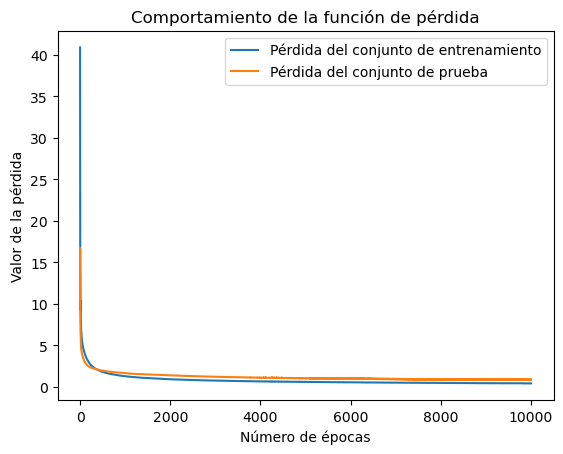

In [5]:
sns.lineplot(lr_tr_loss, label='Pérdida del conjunto de entrenamiento')
sns.lineplot(lr_val_loss,label='Pérdida del conjunto de prueba')
#plt.plot(lr_tr_loss, label='train_loss')
#plt.plot(lr_val_loss,label='val_loss')
plt.legend()
plt.title('Comportamiento de la función de pérdida')
plt.xlabel('Número de épocas')
plt.ylabel('Valor de la pérdida')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

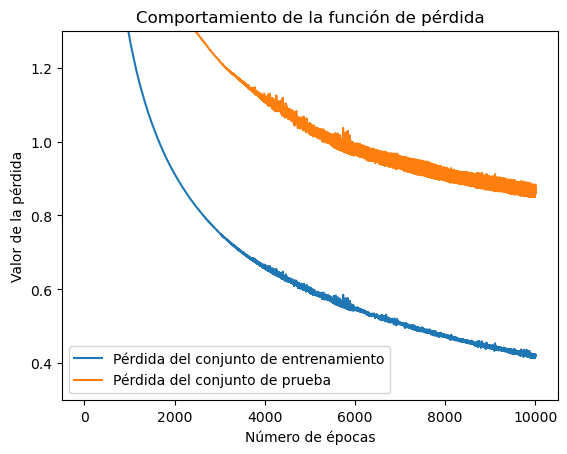

In [6]:
sns.lineplot(lr_tr_loss, label='Pérdida del conjunto de entrenamiento')
sns.lineplot(lr_val_loss,label='Pérdida del conjunto de prueba')

#plt.plot(lr_tr_loss, label='train_loss')
#plt.plot(lr_val_loss,label='val_loss')
plt.legend()
#plt.grid()
plt.title('Comportamiento de la función de pérdida')
plt.xlabel('Número de épocas')
plt.ylabel('Valor de la pérdida')
plt.ylim(0.3,1.3)
plt.show

Cálculo del RMSE

In [61]:
rmse_train = calcular_rmse(lr_tr_loss[-1]) #lo calculamos para el último valor de la lista, i.e. la pérdida registrada en la última época
rmse_test = calcular_rmse(lr_val_loss[-1])

print('RMSE train: ', rmse_train)
print('RMSE test: ', rmse_test)

RMSE train:  0.6498958782215493
RMSE test:  0.938630751176635


## 7.2 Análisis de la salida del modelo

Cargamos el modelo y las matrices de salida guardadas durante el entrenamiento:

In [62]:
#Load the model (Model class must be defined somewhere)
#model = torch.load('model_relu.pt')
model.load_state_dict(torch.load('model_final.pt'))
model.eval()

AutoEncoder(
  (encoder_weights): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 75x90 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 75x75 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 85x75 (GPU 2)]
  )
  (encoder_bias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 75 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 75 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 85 (GPU 2)]
  )
  (decoder_bias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 75 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 75 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 90 (GPU 2)]
  )
)

In [63]:
import pickle

In [64]:
with open('out_train_final.pickle', 'rb') as f:
    out_train = pickle.load(f)

with open('out_test_final.pickle', 'rb') as f:
    out_test = pickle.load(f)

Comparemos la salida con las matrices originales:

Matrices de entrenamiento:

In [65]:
#Input
print(train_original.shape)
adsorbentes_train = train_original['Adsorbente']
columnas_train = train_original.drop(['Adsorbente'],axis=1).columns
train_original

(1161, 91)


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,0.000000,0.844962,0.000000,0.000000,0.301248,0.000000,0.000000,0.000000,...,0.000000,4.343379,3.062861,0.000000,27.645334,3.130662,0.0,0.000000,0.000000,0.000000
1,"(15,15) SWSiCNT",0.000000,0.000000,0.460885,0.000000,1.262480,0.000000,0.179975,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.459049,8.637432,0.000000,0.0,2.344462,2.351026,0.000000
2,"(22,22) SWSiCNT",0.000000,3.040396,0.000000,0.000000,15.397470,0.444007,0.000000,0.000000,0.000000,...,13.341930,0.000000,0.000000,6.373383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,(Cr)-MIL-101-SO3Ag,0.000000,0.000000,0.000000,0.000000,0.000000,1.598743,0.976192,0.000000,0.000000,...,18.540556,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.029259,24.667564,0.000000
4,(Cu(db)),5.991840,1.787435,0.000000,0.000000,0.257570,0.000000,0.491625,0.290457,0.000000,...,4.647121,0.000000,2.697064,2.656299,0.000000,2.806321,0.0,0.000000,0.000000,7.176484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,[Zn(L)].4DMF-a,0.000000,2.736218,1.628760,0.048694,0.000000,0.000000,0.000000,0.000000,0.218797,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.594571,0.0,1.046905,2.437513,0.000000
1157,[Zn(SiF6)(pyz)2]n,6.960437,3.025187,1.658243,0.000000,0.000000,0.870614,0.465319,0.269397,0.000000,...,5.735359,5.418282,4.886020,0.000000,25.311312,4.926080,0.0,17.616823,0.000000,18.987165
1158,[Zn(bdc)(ted)0.5]*2DMF*0.2H2O,0.000000,0.000000,0.371280,0.000000,0.483421,0.432415,0.000000,0.000000,0.000000,...,0.000000,3.632395,0.000000,0.000000,23.199619,7.431206,0.0,0.111912,0.000000,0.000000
1159,[Zn(dcpa)],0.000000,4.208004,2.635701,0.000000,0.000000,0.000000,0.000000,0.000000,0.208724,...,0.000000,5.934405,0.000000,4.983418,31.391222,5.162463,0.0,6.968107,6.614198,0.000000


In [66]:
#Output
print(out_train.shape)
out_train_np = out_train.detach().numpy()
out_train=pd.DataFrame(out_train_np, columns=columnas_train)
out_train.insert(0, 'Adsorbente', adsorbentes_train)
out_train

torch.Size([1161, 90])


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.776436,1.311624,0.481294,-0.236895,2.275545,0.466705,0.323153,0.180003,-0.087172,...,4.172896,3.657493,2.317095,-0.643370,28.421743,2.719216,7.179625,3.281343,6.456729,4.023352
1,"(15,15) SWSiCNT",1.047055,0.892127,0.347155,0.086981,1.176688,0.482582,0.194630,0.084454,-0.053993,...,1.233975,2.708188,1.455487,2.141915,9.056253,1.344084,1.735968,2.436778,1.989610,2.357395
2,"(22,22) SWSiCNT",17.172968,3.624160,2.386237,1.299488,16.174240,0.671285,1.072452,0.047878,0.348733,...,13.004342,4.120477,4.938875,5.323637,3.138927,9.880524,19.454441,9.590805,19.414522,7.231089
3,(Cr)-MIL-101-SO3Ag,20.840166,6.302807,3.318289,-0.424594,4.996804,1.372330,1.071556,0.279631,0.246469,...,17.772640,6.075686,10.648013,9.451855,7.712816,9.033941,24.167068,7.793339,25.755571,7.866775
4,(Cu(db)),4.412542,1.755285,0.968229,0.059401,0.603109,0.691371,0.546921,0.407300,0.690253,...,3.975262,2.519107,3.295961,2.037585,1.763241,2.907313,5.743669,4.504006,7.513697,7.442717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,[Zn(L)].4DMF-a,0.827112,2.749773,1.695576,0.133175,2.862602,0.716010,0.888754,0.536817,0.211898,...,2.362284,2.941926,3.518512,-0.243396,1.626634,3.575077,2.321315,0.795837,2.460480,-0.686802
1157,[Zn(SiF6)(pyz)2]n,7.047579,2.733923,1.654253,0.982236,1.701165,0.628288,0.482706,0.223677,0.371210,...,5.797648,4.931883,4.902278,1.156252,25.085325,5.176347,9.037039,17.570044,9.861723,18.543440
1158,[Zn(bdc)(ted)0.5]*2DMF*0.2H2O,-2.563475,1.092243,0.342248,1.929539,0.444290,0.593197,0.920982,0.461795,0.476072,...,1.626791,3.627232,2.924336,0.043308,23.141041,7.556455,1.238013,0.144632,1.317472,-0.099558
1159,[Zn(dcpa)],5.365580,4.042218,2.654756,0.494154,3.873572,0.458373,1.273162,0.691199,0.169764,...,5.543148,5.610611,5.616192,4.977527,31.497599,5.271154,6.514036,7.341928,6.851272,3.104449


In [67]:
matriz_completa

,Unnamed: 0,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,((Me2NH2)In(NH2BDC)2),4.033310,1.792624,0.844962,0.000000,0.037800,0.301248,0.315355,0.109140,0.000000,...,3.252520,4.343379,3.062861,7.023981,27.645334,3.130662,4.991338,11.163347,6.986485,11.954864
1,"(15,15) SWSiCNT",1.139975,0.885577,0.460885,0.000000,1.262480,0.405857,0.179975,0.036291,0.000000,...,1.224523,2.756256,1.385274,1.459049,8.637432,1.470981,1.710555,2.344462,2.351026,3.173570
2,"(22,22) SWSiCNT",20.021545,3.040396,0.990242,0.000000,15.397470,0.444007,0.176597,0.014436,0.000000,...,13.341930,4.159455,8.135298,6.373383,50.843555,7.236180,21.686472,19.889746,16.274437,19.158159
3,(Cr)-MIL-101-SO3Ag,25.758533,6.673483,3.845711,0.160661,18.111420,1.598743,0.976192,0.762010,0.288756,...,18.540556,6.263205,11.620084,10.215974,50.234863,10.908710,27.539465,6.029259,24.667564,28.294613
4,(Cu(db)),5.991840,1.787435,0.920272,0.000000,0.257570,0.084687,0.491625,0.290457,0.000000,...,4.647121,4.533251,2.697064,2.656299,24.488384,2.806321,6.743752,6.470298,7.281785,7.176484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,1.079469,0.597944,0.000000,0.012183,0.474581,0.244710,0.047634,0.000000,...,1.980017,3.133307,1.682327,1.031747,3.965266,1.772706,3.037405,6.378811,5.463107,6.944499
1257,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.269992,0.311977,0.079905,0.000000,0.834529,0.103914,0.000000,0.000000,0.000000,...,0.346684,1.800818,0.402631,0.541453,1.890479,0.468515,0.450423,0.081222,0.810060,0.257930
1258,{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,2.136436,1.153096,0.025261,0.832732,0.829907,0.523100,0.368113,0.156124,...,1.549578,4.538204,2.999756,3.278202,24.443693,2.911840,1.229138,0.984888,1.959672,1.787560
1259,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},2.622934,1.725868,0.963068,0.000000,2.947596,0.707617,0.596164,0.398727,0.101568,...,3.318505,1.635280,2.231190,2.589295,10.409521,2.305397,3.507734,1.525428,3.373003,2.186897


Matrices de prueba:

In [68]:
#Input
print(test_original.shape)
adsorbentes_test = test_original['Adsorbente']
columnas_test = test_original.drop(['Adsorbente'],axis=1).columns
test_original

(100, 91)


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.000000,0.947108,0.000000,0.0,0.000000,0.061256,0.00000,0.222439,0.000000,...,0.000000,0.000000,1.328918,12.008529,0.000000,1.433456,0.557101,0.600753,0.000000,0.000000
1,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,2.029916,1.086210,...,11.867601,7.443300,0.000000,8.771895,0.000000,8.670429,15.977197,24.873333,0.000000,0.000000
2,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,1.075090,0.784983,0.000000,0.0,0.000000,0.712871,0.00000,0.203600,1.000000,...,0.000000,4.699669,0.000000,3.052692,0.000000,0.000000,9.178073,8.817957,8.053491,9.396001
3,[Zn2(CN5H2)3(H2O)3]6H2O,6.189885,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.590219,0.000000,...,0.684472,5.431553,4.832698,4.678391,25.974585,4.855744,0.000000,14.810995,0.000000,16.039534
4,[Zn2(CN5H2)3(H2O)3]6H2O Ac,0.487708,0.000000,0.417787,0.0,0.000000,0.000000,0.00000,0.164744,0.000000,...,0.758638,2.966201,1.025537,1.067146,0.000000,0.000000,0.833559,1.440450,0.000000,2.190897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,0.000000,0.597944,0.0,0.012183,0.474581,0.24471,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.037405,0.000000,0.000000,6.944499
96,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.800818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.257930
97,{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,0.000000,0.000000,0.0,0.000000,0.000000,0.52310,0.000000,0.000000,...,0.000000,4.538204,0.000000,3.278202,24.443693,0.000000,0.000000,0.000000,1.959672,1.787560
98,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},2.622934,0.000000,0.963068,0.0,2.947596,0.707617,0.00000,0.000000,0.101568,...,0.000000,0.000000,0.000000,2.589295,0.000000,0.000000,3.507734,0.000000,0.000000,2.186897


In [69]:
#Output
print(out_test.shape)
out_test_np = out_test.detach().numpy()
out_test=pd.DataFrame(out_test_np, columns=columnas_test)
out_test.insert(0, 'Adsorbente', adsorbentes_test)
out_test

torch.Size([100, 90])


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.414407,1.506064,0.847652,-0.822543,-0.988835,-0.430057,-0.004914,0.366937,-0.309695,...,1.355122,2.312035,2.132678,11.026027,3.452049,1.274993,1.600893,1.286071,1.690701,1.740997
1,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,10.981824,5.051598,3.834434,-0.203325,1.796480,1.818201,1.607555,1.047155,1.183068,...,9.889935,9.195485,7.408055,7.649546,1.281817,7.884098,16.106005,20.133865,16.381830,12.911913
2,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,5.187232,2.503776,1.388817,0.342314,2.052322,1.730125,0.540168,0.287437,1.439028,...,3.737534,7.587290,4.052664,2.481123,-1.295412,3.105517,6.628393,12.629663,9.640047,11.310090
3,[Zn2(CN5H2)3(H2O)3]6H2O,6.715715,4.491516,3.082927,-0.231025,1.830375,0.652009,1.013347,0.911666,0.623311,...,5.151757,5.696745,5.410547,3.880809,26.363131,5.925551,8.335501,16.136581,9.267009,16.841850
4,[Zn2(CN5H2)3(H2O)3]6H2O Ac,1.076094,1.073566,0.711624,0.107028,0.973503,0.419721,0.420839,0.235244,0.049533,...,1.593197,2.798856,1.433514,1.101846,0.535202,1.505108,1.567734,2.367908,1.866475,2.815332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,3.136024,1.553625,0.859762,-0.279603,0.973128,0.425232,0.202417,0.262708,0.028673,...,2.521842,2.865423,2.008361,0.662754,0.552428,2.068458,3.860674,1.739702,4.005394,5.470305
96,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,-0.110232,0.254824,0.053545,-0.087090,-0.015071,0.275953,0.110918,-0.050147,0.009063,...,0.672211,1.997462,0.453148,0.756816,0.294518,0.248152,-0.067518,-0.469263,0.392806,0.807022
97,{[Zn3(ptp)3](DMF)2-(H2O)},0.567948,1.732720,0.973772,0.256937,1.265839,0.521370,0.510770,0.337247,-0.021136,...,1.427909,3.275464,2.166761,2.847440,24.648577,2.181261,0.988928,1.103114,1.327566,1.914241
98,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},3.289324,1.696383,1.110681,0.008969,2.980494,0.584895,0.549574,0.497157,0.137655,...,2.608678,2.074322,1.732297,2.484764,1.724159,1.676423,3.208954,0.206074,2.779967,2.217655


In [70]:
matriz_completa.loc[1161:]

,Unnamed: 0,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
1161,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.224950,0.947108,0.410696,0.000000,0.426562,0.061256,0.336424,0.222439,0.000000,...,0.926431,3.589091,1.328918,12.008529,27.397602,1.433456,0.557101,0.600753,1.312219,1.310543
1162,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,0.614334,0.426621,4.680773,1.364516,10.207487,2.919017,2.282054,2.029916,1.086210,...,11.867601,7.443300,8.694467,8.771895,13.490376,8.670429,15.977197,24.873333,20.561518,26.137405
1163,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,1.075090,0.784983,0.958314,0.000000,4.359735,0.712871,0.400815,0.203600,1.000000,...,5.934858,4.699669,3.159377,3.052692,34.664043,3.220671,9.178073,8.817957,8.053491,9.396001
1164,[Zn2(CN5H2)3(H2O)3]6H2O,6.189885,3.143266,1.843922,0.061818,0.749636,1.161629,0.781746,0.590219,0.247043,...,0.684472,5.431553,4.832698,4.678391,25.974585,4.855744,7.174445,14.810995,8.651445,16.039534
1165,[Zn2(CN5H2)3(H2O)3]6H2O Ac,0.487708,0.751394,0.417787,0.000000,1.011861,0.487463,0.291085,0.164744,0.000000,...,0.758638,2.966201,1.025537,1.067146,29.718618,1.097882,0.833559,1.440450,1.970905,2.190897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,2.183324,1.079469,0.597944,0.000000,0.012183,0.474581,0.244710,0.047634,0.000000,...,1.980017,3.133307,1.682327,1.031747,3.965266,1.772706,3.037405,6.378811,5.463107,6.944499
1257,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,0.269992,0.311977,0.079905,0.000000,0.834529,0.103914,0.000000,0.000000,0.000000,...,0.346684,1.800818,0.402631,0.541453,1.890479,0.468515,0.450423,0.081222,0.810060,0.257930
1258,{[Zn3(ptp)3](DMF)2-(H2O)},0.597666,2.136436,1.153096,0.025261,0.832732,0.829907,0.523100,0.368113,0.156124,...,1.549578,4.538204,2.999756,3.278202,24.443693,2.911840,1.229138,0.984888,1.959672,1.787560
1259,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},2.622934,1.725868,0.963068,0.000000,2.947596,0.707617,0.596164,0.398727,0.101568,...,3.318505,1.635280,2.231190,2.589295,10.409521,2.305397,3.507734,1.525428,3.373003,2.186897


## Distribución de los errores

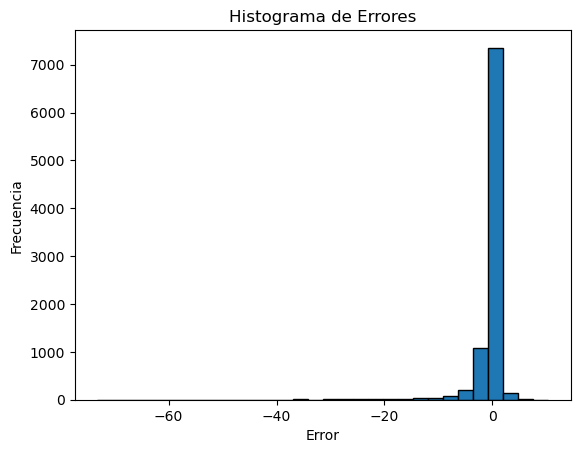

In [132]:
# Calcular los errores
predicciones_test = out_test.iloc[:, 1:].values
originales_test = matriz_completa.iloc[1161:, 1:].values
errores = predicciones_test - originales_test

# Graficar el histograma de errores
plt.hist(errores.flatten(), bins=30, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores en las matrices de pruebas')
plt.show()

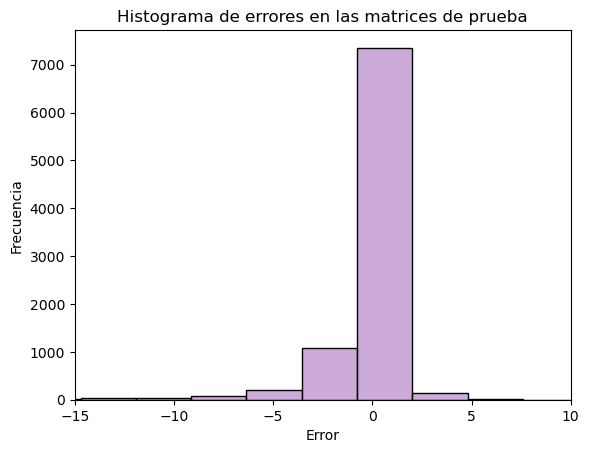

In [142]:
# Calcular los errores
predicciones_test = out_test.iloc[:, 1:].values
originales_test = matriz_completa.iloc[1161:, 1:].values
errores = predicciones_test - originales_test

# Graficar el histograma de errores
sn.histplot(errores.flatten(), bins=30, edgecolor='black', color='#BB8FCE')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores en las matrices de prueba')
plt.xlim(-15,10)
plt.show()

In [135]:
rango_datos_originales = np.max(originales_test) - np.min(originales_test)
rango_predicciones = np.max(predicciones_test) - np.min(predicciones_test)

print("Rango de datos originales:", rango_datos_originales)
print("Rango de predicciones:", rango_predicciones)

Rango de datos originales: 81.95346069335938
Rango de predicciones: 86.601425


# Paso 8: Generación del flujo para un nuevo conjunto de datos

En esta última sección se presenta el flujo a seguir cuando se tenga un nuevo conjunto de datos, para el que se busque obtener predicciones a partir del modelo entrenado. Cuando se tenga un nuevo conjunto de datos, este debe tener la misma cantidad de columnas de las matrices utilizadas durante el entrenamiento, el número de filas es libre. La interpretación de lo anterior hace referencia a que se predecirán las capacidades de adsorción para cualquier cantidad de adsorbentes, para todos los gases considerados en el entrenamiento.

## 8.1 Preparación de los datos

In [71]:
ruta_datos = '/home/celeste/tesis/recommender/Recommender-Adsorbentes/test_50porciento_random.csv'
batch_size = 8

In [72]:
test_dl = prepare_newdata(ruta_datos, batch_size)

## 8.2  Proceso de predicción

En esta sección se emplea la función predict construida previamente.

In [73]:
predict(model, criterion, test_dl)

Loss (MMSE):  0.881027687054414
Matrix shape:  torch.Size([100, 90])
RMSE:  0.938630751176635


tensor([[ 0.4144,  1.5061,  0.8477,  ...,  1.2861,  1.6907,  1.7410],
        [10.9818,  5.0516,  3.8344,  ..., 20.1339, 16.3818, 12.9119],
        [ 5.1872,  2.5038,  1.3888,  ..., 12.6297,  9.6400, 11.3101],
        ...,
        [ 0.5679,  1.7327,  0.9738,  ...,  1.1031,  1.3276,  1.9142],
        [ 3.2893,  1.6964,  1.1107,  ...,  0.2061,  2.7800,  2.2177],
        [ 3.7339,  2.0807,  0.9284,  ...,  1.6942,  4.4501,  2.5394]],
       grad_fn=<CatBackward>)

Definimos una función que automatice la reconstrucción de la matriz a partir del tensor de salida del modelo:

In [74]:
def reconstruir_salida(matriz_original, matriz_dl):
    columnas = matriz_original.drop(['Adsorbente'],axis=1).columns
    adsorbentes = matriz_original['Adsorbente']
    
    salida= predict(model, criterion, matriz_dl)
    salida = salida.detach().numpy()
    salida = pd.DataFrame(salida, columns=columnas)
    salida.insert(0, 'Adsorbente', adsorbentes)
    
    return salida 

In [75]:
pred = reconstruir_salida(test_original, test_dl)
pred

Loss (MMSE):  0.881027687054414
Matrix shape:  torch.Size([100, 90])
RMSE:  0.938630751176635


,Adsorbente,0_acetylene273,0_acetylene298,0_argon298,0_butane298,0_carbon dioxide273,0_carbon dioxide298,0_carbon dioxide323,0_carbon monoxide298,0_ethane273,...,3_nitrogen273,3_nitrogen298,3_nitrogen323,3_nitrogen77,3_oxygen298,3_propane298,3_propane323,3_propene298,3_propene323,3_xenon298
0,[Zn12(SO3)2(BTB)6(HCO2)3].15DEF,0.414407,1.506064,0.847652,-0.822543,-0.988835,-0.430057,-0.004914,0.366937,-0.309695,...,1.355122,2.312035,2.132678,11.026027,3.452049,1.274993,1.600893,1.286071,1.690701,1.740997
1,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 1a,10.981824,5.051598,3.834434,-0.203325,1.796480,1.818201,1.607555,1.047155,1.183068,...,9.889935,9.195485,7.408055,7.649546,1.281817,7.884098,16.106005,20.133865,16.381830,12.911913
2,[Zn17thb14(mu4-O)4(H2O)(Me2NH2)]*Me2NH2 2a,5.187232,2.503776,1.388817,0.342314,2.052322,1.730125,0.540168,0.287437,1.439028,...,3.737534,7.587290,4.052664,2.481123,-1.295412,3.105517,6.628393,12.629663,9.640047,11.310090
3,[Zn2(CN5H2)3(H2O)3]6H2O,6.715715,4.491516,3.082927,-0.231025,1.830375,0.652009,1.013347,0.911666,0.623311,...,5.151757,5.696745,5.410547,3.880809,26.363131,5.925551,8.335501,16.136581,9.267009,16.841850
4,[Zn2(CN5H2)3(H2O)3]6H2O Ac,1.076094,1.073566,0.711624,0.107028,0.973503,0.419721,0.420839,0.235244,0.049533,...,1.593197,2.798856,1.433514,1.101846,0.535202,1.505108,1.567734,2.367908,1.866475,2.815332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,{[Zn2(OH)(AZPY)(BDC)1.5]*H2O}n,3.136024,1.553625,0.859762,-0.279603,0.973128,0.425232,0.202417,0.262708,0.028673,...,2.521842,2.865423,2.008361,0.662754,0.552428,2.068458,3.860674,1.739702,4.005394,5.470305
96,{[Zn3(L)3(DPB)1.5]-6DMF-H20}n,-0.110232,0.254824,0.053545,-0.087090,-0.015071,0.275953,0.110918,-0.050147,0.009063,...,0.672211,1.997462,0.453148,0.756816,0.294518,0.248152,-0.067518,-0.469263,0.392806,0.807022
97,{[Zn3(ptp)3](DMF)2-(H2O)},0.567948,1.732720,0.973772,0.256937,1.265839,0.521370,0.510770,0.337247,-0.021136,...,1.427909,3.275464,2.166761,2.847440,24.648577,2.181261,0.988928,1.103114,1.327566,1.914241
98,{[Zn4(BDC)4(BPDA)4]*5DMF*3H2O},3.289324,1.696383,1.110681,0.008969,2.980494,0.584895,0.549574,0.497157,0.137655,...,2.608678,2.074322,1.732297,2.484764,1.724159,1.676423,3.208954,0.206074,2.779967,2.217655


Una vez teniendo la matriz completa, se puede utilizar para realizar recomendaciones de adsorbentes a partir del análisis de las capacidades de adsorción. 

Para mayor información revisar la tesis de Celeste Castro Granados. 

# Parámetros finales del modelo

* Arquitectura de red: 90, 75, 75, 85
* Función de activación: relu
* Función de pérdida: MSE Enmascarada
* lr: 0.001
* optimizador: SGD
* Constrained: True
* Dropout: 0.0
* Last layer activations: False
* Núm épocas: 10 000
* RMSE test: 0.9386